# Обучение с учителем: качество модели

# Описание проекта
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. Нужно разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Цель проекта 
Разработать и внедрить систему персонализированных предложений для постоянных клиентов интернет-магазина "В один клик" с целью удержания активности постоянных клиентов и увеличения их покупательской активности.
### План проекта 

[**Шаг 0. Импорт библиотек, методы**](#step_00)

[**Шаг 1. Загрузка данных**](#step_01)

[**Шаг 2. Предобработка данных**](#step_02)

[**Шаг 3. Исследовательский анализ**](#step_03)

[**Шаг 4. Объединение таблиц**](#step_04)

[**Шаг 5. Корреляционный анализ**](#step_05)

[**Шаг 6. Использование пайплайнов**](#step_06)

[**Шаг 7. Анализ важности признаков**](#step_07)

[**Шаг 8. Сегментация покупателей**](#step_08)

[**Шаг 9. Вывод**](#step_09)



# Шаг 0. Импорт библиотек, методы


<a id="step_00"></a>

In [1]:
''' 
Добрый день! Если в проекте возникнет конфликт между нашими библиотеками, раскоментируй, пожалуйста, этот код
'''
#! conda install -y numpy'>=1.22 <=1.26'
! pip install shap 
#! pip install -U scikit-learn

In [2]:
#импорт нужных библиотек
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import  SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Методы

In [3]:
def duplicates(columns, df):
    for column in columns:
        unique_values = df[column].unique()
        print(f'Уникальные значения в колонке {column}: {unique_values}')

In [4]:
def create_histogram(data, column):
    """
    Input:
    - data: Датафрейм, содержащий данные.
    - column: Наименование столбца, для которого нужно построить гистограмму.
    - title: Заголовок гистограммы.
    - bins: Количество бинов для гистограммы (по умолчанию 50)

    Output:
    - None

    Description:
    Функция создает гистограмму для указанного столбца в датафрейме при помощи библиотеки seaborn. 
    Результат выводится на экран.
    """
    plt.figure(figsize=(12, 6))
    sns.set()
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    sns.histplot(data=data, x=column, kde=True, bins=num_bins)
    plt.title(f'{column} - Плотность распределения', fontsize=18)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [5]:
def create_barplot(data, column, rotation=45):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, для которой нужно построить диаграмму.
    - title (str): Заголовок для столбчатой диаграммы.
    
    Output:
    None

    Description:
    Функция создает столбчатую диаграмму на основе данных из указанной колонки.
    """
    plt.figure(figsize=(10, 6))
    plt.xticks(rotation=rotation)
    new_data = data[column].value_counts()
    df_new_data = new_data.reset_index()
    df_new_data.columns = [column, 'count']

    sns.barplot(x=column, y='count', data = df_new_data)
    plt.title(f'{column}.Плотность распределения')
    plt.xlabel(f'{column}')
    plt.ylabel(f'количество {column}')

In [6]:
def cat_num_col(df):
    """
    Input:
    - df(DataDrame): Исходный DataFrame с данными
    Output:
    - num_col_names(list) - список столбцов с количественными признаками
    - cat_col_names(list) - список столбцов с категориальными признаками

    Description:
    Функция возвращает списки с названиями столбцов категориальных и количественных признаков. id из списка удаляется

    """
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    num_col_names.remove('id')
    return num_col_names, cat_col_names

In [7]:
def shapiro_test(data, column):
    """
    Функция выполняет тест Шапиро-Уилка на нормальность данных в указанном столбце.

    Параметры:
        - data: pandas DataFrame, входные данные
        - column: str, название столбца, для которого выполняется тест

    Вывод:
        - печать результата теста Шапиро-Уилка, включая статистику теста и p-значение
        - вывод сообщения о том, является ли распределение данных нормальным
    """ 
    statistic, p_value = shapiro(data[column])

    # Печать результата теста
    alpha = 0.05  # Уровень значимости
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

In [8]:
def scatter_dataframe(df):
    num_cols = df.select_dtypes(exclude='object').columns.to_list()
    parameters = []
    for i in num_cols:
        for j in num_cols:
            if (i != j) and (i != 'id') and (j != 'id'):
                if ((i, j) not in parameters) and ((j, i) not in parameters):
                    df.plot(x=i, y=j, kind='scatter')
                    k = i, j
                    parameters.append(k)
    None
    

In [9]:
def create_boxplot(data, column):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, которая будет отображена на оси x.
    
    Output:
    None
    
    Description:
    Функция создает график ящика с усами на основе указанных столбцов.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Ящик с усами для {column}')
    plt.xlabel(column)
    plt.show()


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично! Красивые функции. Ну и здорово что ты понимаешь, что применение функций упрощает код, делает его структурированным, простым для понимания и упрощает его дальнейшее переиспользование (принцип DRY (Don’t Repeat Yourself / Не повторяйся) – в действии). Дополнительно о DRY можно почитать здесь: https://habr.com/ru/company/itelma/blog/546372</div>

# Шаг 1. Загрузка данных


<a id="step_01"></a>

In [10]:
try:
    df_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    df_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    df_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', decimal=',')
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal=',')
except Exception:
    print('Упc, кажется такого файла нет')

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Конструкция try..except должна именно обрабатывать ошибку (в этом её глубинный смысл), а не просто выводить некое сообщение.
</div>

### **Изучим данные df_market_file**

In [11]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

<div class="alert alert-warning">
<b>Комментарий 👉</b>

В наших данных пропусков НЕТ, НО ЕСЛИ БЫ БЫЛИ .... я стараюсь дать подробный коммент-видение на тему обработки пропусков данных (так как понимаю, что несмотря на кажущуюся простоту - не очень просто понять чем ("заглушкой"? / медианой? / средним? / по комбинации столбцов?) заполнять? а может удалять?      

---    
По результатам проверки примерно 3,6 тысяч проектов за крайние 1,5 года у меня родилось небольшое эссе на тему "удаления vs. спасения" данных, как раз на основе тех ситуаций и вопросов, которые мне коллеги задавали, которые мы обсуждали, уточняли и исправляли ... 

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>Подробнее ...</u></summary>

Желание уменьшить количество пропусков в данных (если такое желание конечно возникает ... но в рабочих проектах, "в жизни" оно как правило возникает) - можно только приветствовать. Приветствовать по 3-м минимум причинам:

1. это тренировка
    
2. это попытка сохранить данные ("данных много не бывает")
    
3. самое главное на мой взгляд - развитие аналитического мышления, желания "проникать" в секреты, которые скрывают данные. Когда вначале рождается гипотеза, потом эта гипотеза проверяется на данных (может ли такое быть? подтверждается?) и в финале уже гипотеза облекается в код.

Однако заполнение пропусков в данных не такая простая задача, как кажется ... простого ответа на вопросы: заполнять? удалить? чем заполнять? подходящего под все сценарии, нет ни в одной умной книжке ...

Самый идеальный случай - когда у тебя под рукой есть эксперт в предметной области. Если такой есть - советуйся с ним. Как правило это человек из бизнеса, который знает суть бизнес-процесса и вот именно он даст тебе точный и аргументированный совет - что в данной, конкретной задаче делать с "битыми" полями в строках датафрейма. Ты скажешь ему какой процент пропусков в данных, а он тебе ответит что делать: можно/нельзя удалить и/или даст рекомендации по заполнению. Вообще, как правило такой человек "на любой работе" есть. Для примера, финансовый директор думаю всегда даст рекомендации по финансовым данным, прочие профильные спецы - по своей сфере компетенций. Наверное только в зарождающемся стартапе может не быть каких-то компетенций, но тут уже можно и через фриланс (и т.п.) попробовать найти спеца и просить совета.

Теперь, что делать, если такого человека нет. Я бы ответил так: **ПОПЫТАТЬСЯ** вникнуть в бизнес-проблему самому. Наверное это сложно, если предметная область ну совсем незнакома. Но в общем случае, если бизнес совсем незнаком, то заполнение пропусков в данных наверное, не получиться. В таком случае попробуй ориентироваться на такое правило: если записи с пропусками в ключевых для твоего анализа столбцах составляют 1-3-5-ну может до 10% строк, то попробуй эти записи из оригинального датафрейма вырезать (но сохрани бы в некий df, к которому ты при необходимости можешь всегда обратиться).

В жизни, МНЕ КАЖЕТСЯ, как правило по всему датафрейму заполнять медианой/средним - ну вообще не вариант. Почему? Я бы ответил так - потому, что реальные датафреймы имеют миллионы строк и горизонт в несколько (десятков) лет, и если в 90-2000-е года всё было как-то более -менее стабильно/прогнозируемо, то в нынешней реальности события раскручиваются гораздо быстрее и не прогнозируемо. Пример: ты аналитик в автобизнесе. У тебя есть данные с пропусками в цене для машин в 2005-2007 года. Можно заполнить их средними основываясь на данных 2020-2021?

Может быть и такой вариант, что без заполнения некоторых столбцов некоторые записи по сути **НЕ** имеют смысла, но если их (записи с пропусками удалить), то и данных-то не останется. Ну тогда я бы такой совет дал - всё же заполнять медианой (она к скачкам выбросов более устойчива), но не по всему глобальному датафрейму, а выбрать простые группы (например, группы по интервалу лет - чтобы сгладить турбулентность нынешних лет) или выбрать более сложные группы (например, группы по интервалу лет и одновременно марке автопроизводителя (это я про вымышленный пример с автобизнесом)).

Теперь предположим, что мы выбрали какую-то стратегию заполнения "пропусков", не суть какую (оставить NaN или заполнить "заглушкой"). И в том и в другом случае придётся помнить этот выбор. Ты спросишь почему? Отвечу - потому, что инструменты, применяемые тобой в Питон/Пандас в каких-то случаях могут спокойно пропускать твой выбор, а в каких-то случаях тебе придется этот твой выбор обрабатывать.

Пример 1: мы заполнили пропуски "заглушкой". В этом случае: 1. расчет корреляций значение "заглушку" будет "ловить" (надо отфильтровать!), 2. расчет гипотез также будет "сбивать" правильный вывод (надо отфильтровать!) 3. графики, которые ты будешь строить - будут "заглушку" отображать на осях (нужно фильтровать), 4. в группировках также по-видимому "заглушку" надо будет убирать.

Пример 2: мы оставили пропуски как NaN. В этом случае: 1. метод .corr NaN'ы пропускает (отфильтровать не надо), 2. в расчет гипотез всё равно пропуски отфильтровать 3. графики, которые ты будешь строить могут отображать, а могут не отображать, 4. в группировках NaN'ы по sum() видны не будут, а по count() будут.

Ну и напоследок совсем уже жёсткий пример: додумывать "от себя", бездумно проставлять в пропуски медианные/средние значения - это НЕ верно. Давай же опять "про жизнь". Я писал выше, что в медицине работаю, да? **Предположим** мне принесли данные из онкологического диспансера. Задача: построить модель, которая по некоторым маркерным анализам будет прогнозировать наличие онкологии. **По-простому, ответить, что стоит за строчкой в данных: жизнь или смерть.** Уууууух … аж мороз по коже продирает, правда? 

Итак, 1.000.000 записей и 70 столбцов. Данные за 25 лет. 70 столбцов - это поля, с результатами конкретных и очень специфичных анализов. В "начале" данных, 15-20 лет назад, есть пропуски (много), но и в принципе, в данных есть пропуски. Как думаешь - имею я моральное право перед людьми, которые фактически доверяют мне в виде данных свою жизнь огульно подойти к заполнению пропусков?

</details>
<br>
<br>
</div>


In [12]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Данный датафрейм содержит информацию о 1300 записях с 13 столбцами. Типы данных включают в себя int64, float64 и object. Столбцы представляют собой различные аспекты
В датафрейме есть следующие столбцы:
* **Покупательская активность** — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

* **Тип сервиса** — уровень сервиса, например «премиум» и «стандарт».

* **Разрешить сообщать** — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

* **Маркет_актив_6_мес** — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

* **Маркет_актив_тек_мес** — количество маркетинговых коммуникаций в текущем месяце.

* **Длительность** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

* **Акционные_покупки** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

* **Популярная_категория** — самая популярная категория товаров у покупателя за последние 6 месяцев.

* **Средний_просмотр_категорий_за_визит** — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

* **Неоплаченные_продукты_штук_квартал** — общее число неоплаченных товаров в корзине за последние 3 месяца.

* **Ошибка_сервиса** — число сбоев, которые коснулись покупателя во время посещения сайта.

* **Страниц_за_визит** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

### **Изучим данные df_market_money**

In [13]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [14]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Данный датафрейм состоит из 3900 записей с 3 столбцами
В датафейме есть следующие столбцы

* **id** — номер покупателя в корпоративной базе данных.

* **Период** — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

* **Выручка** — сумма выручки за период.

### **Изучим данные df_market_time** 

In [15]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [16]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Данный датафрейм состоит из 2600 записей с 3 столбцами
* **id** — номер покупателя в корпоративной базе данных.

* **Период** — название периода, во время которого зафиксировано общее время.

* **минут** — значение времени, проведённого на сайте, в минутах.

### **Изучим данные df_money** 

In [17]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [18]:
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Вывод 
Проверили первичный просмотр всех предоставленных данных

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Хорошо, данные загрузили, первичные проверки сделали.
</div>

# Шаг 2. Предобработка данных

<a id="step_02"></a>

**Изучим дубликаты**

In [19]:
data_frames = [df_market_file, df_market_money, df_market_time, df_money]

for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace=True)
        print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме df_market_file: 0
Количество дубликатов в датафрейме df_market_money: 0
Количество дубликатов в датафрейме df_market_time: 0
Количество дубликатов в датафрейме df_money: 0


<div class="alert alert-warning">
<b>Комментарий 👉</b>

**df.duplicated().sum() == 0** не означает, что в данных нет дубликатов (записей). 
    
В реальных рабочих датасетах скорее всего не будет полных дубликатов, но вот неявные наверняка будут встречаться, соответственно с ними надо будет уметь работать. Для поиска неявных дублей обычно используют параметр **subset** у функции duplicated(). Правда здесь, в нашем проекте, надо поразмыслить над тем какие комбинации столбцов могут говорить о реальных дублях в данных.</div>

Проверим неявные дубликаты. Если они есть - заменим 

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Это не неявные дубликаты, а скорее ошибки в данных. Неявными дублями называются строки, которые совпадают НЕ полностью, а по некоторому набору столбцов.
</div>

In [20]:
print('df_market_file')
columns = ['Покупательская активность', 'Тип сервиса', 'Популярная_категория', ]
duplicates(columns, df_market_file)
print()
print('df_market_money')
columns = ['Период']
duplicates(columns, df_market_money)
print()
print('df_market_time')
duplicates(columns, df_market_time)


df_market_file
Уникальные значения в колонке Покупательская активность: ['Снизилась' 'Прежний уровень']
Уникальные значения в колонке Тип сервиса: ['премиум' 'стандартт' 'стандарт']
Уникальные значения в колонке Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

df_market_money
Уникальные значения в колонке Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

df_market_time
Уникальные значения в колонке Период: ['текущий_месяц' 'предыдцщий_месяц']


In [21]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace('стандартт','стандарт')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, молодец, обнаружено первое (из 2х) "разночтений" по факту одних и тех же категорий в признаках.</div>

In [22]:
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Второе "разночтение" также обнаружено и исправлено!</div>

**Изучим пропуски**

In [23]:
for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'прошущенные значения в {data_name}:\n{data.isnull().sum().sort_values()}')
    print()

прошущенные значения в df_market_file:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

прошущенные значения в df_market_money:
id         0
Период     0
Выручка    0
dtype: int64

прошущенные значения в df_market_time:
id        0
Период    0
минут     0
dtype: int64

прошущенные значения в df_money:
id         0
Прибыль    0
dtype: int64



<div class="alert alert-warning">
<b>Комментарий 👉</b>

По результатам info() выше уже было видно что пропусков в данных нет. В принципе эту проверку можно было бы и не делать, она избыточной кажется.
</div>

### Вывод 
1) Пропусков и дубликатов в датафрйемах не обнаружено
2) Неявные дубликаты, которые возникли из-за опечаток, устранили 

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Есть, отлично!
</div>

# Шаг 3. Исследовательский анализ данных

<a id="step_03"></a>

### Проведем исследовательский анализ данных df_market_file

In [24]:
df_market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


<div class="alert alert-warning">
<b>Комментарий 👉</b>

describe() играет важную роль в понимание распределения статистик признаков в данных. Отсюда можно увидеть аномалии, выбросы. Просто "посмотреть" на эти таблички недостаточно, обязательно нужен вывод по анализу результата describe().
</div>

Выведем графики

In [25]:
num_col_names_market, cat_col_names_market = cat_num_col(df_market_file)

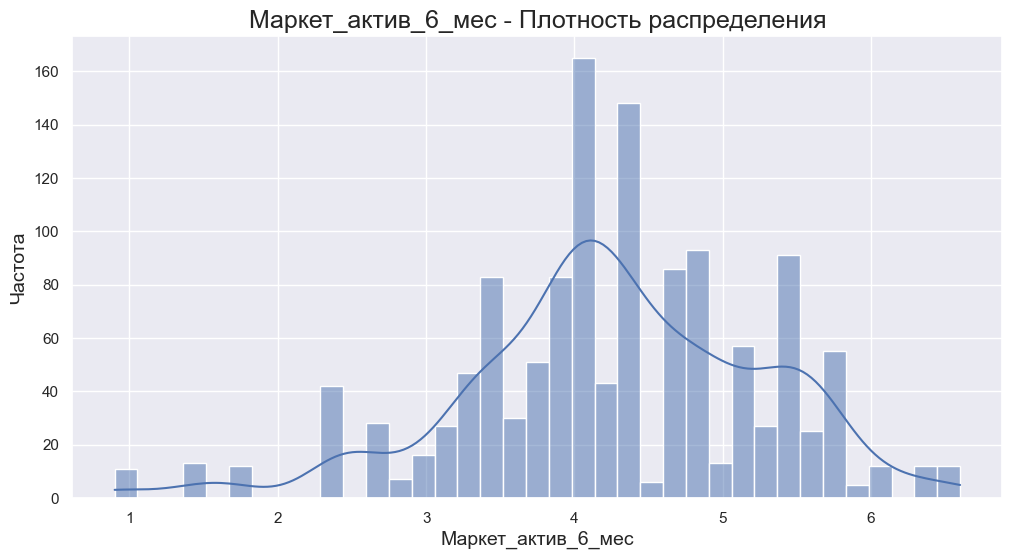

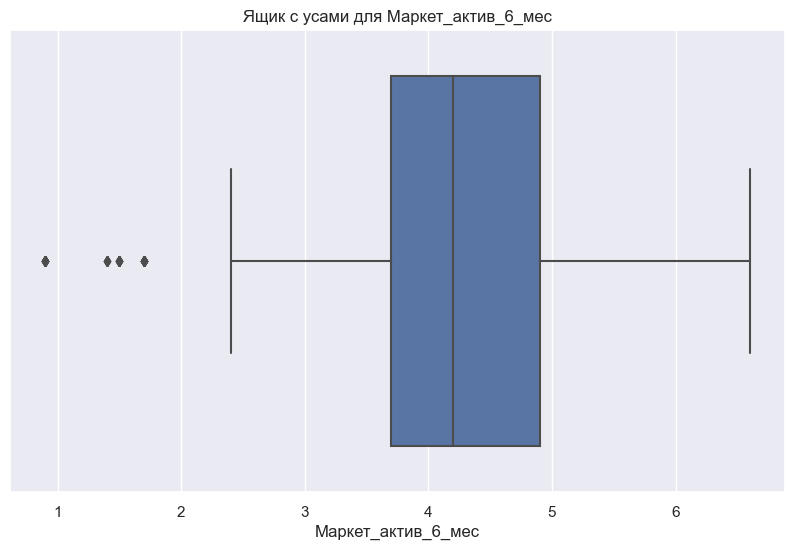

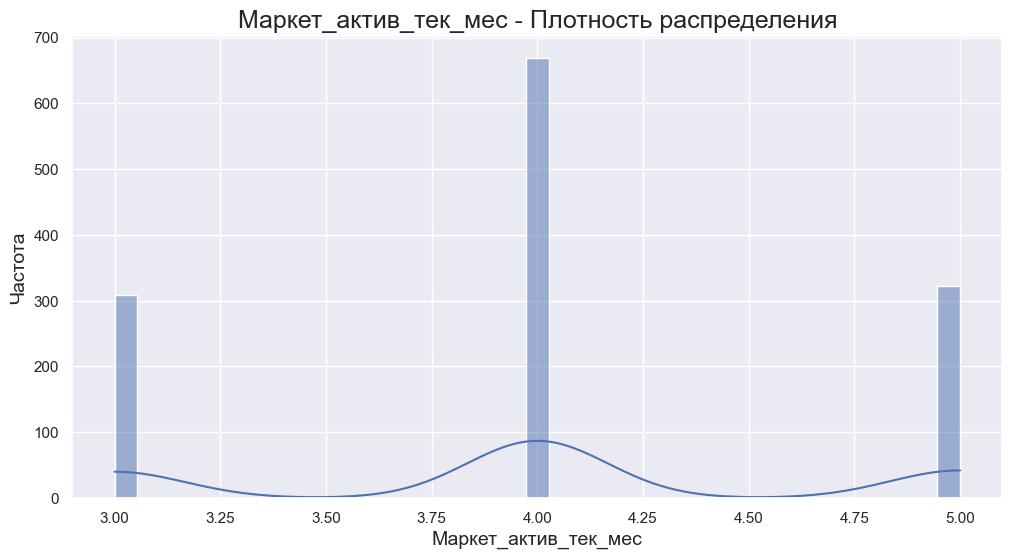

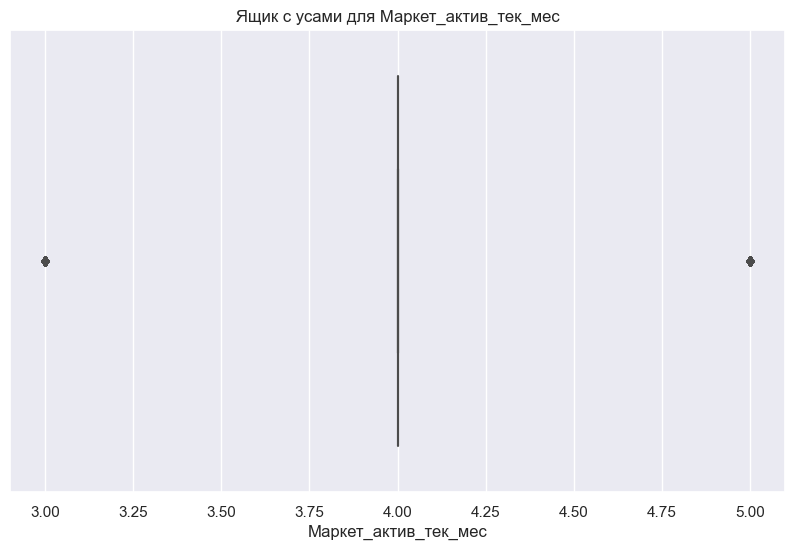

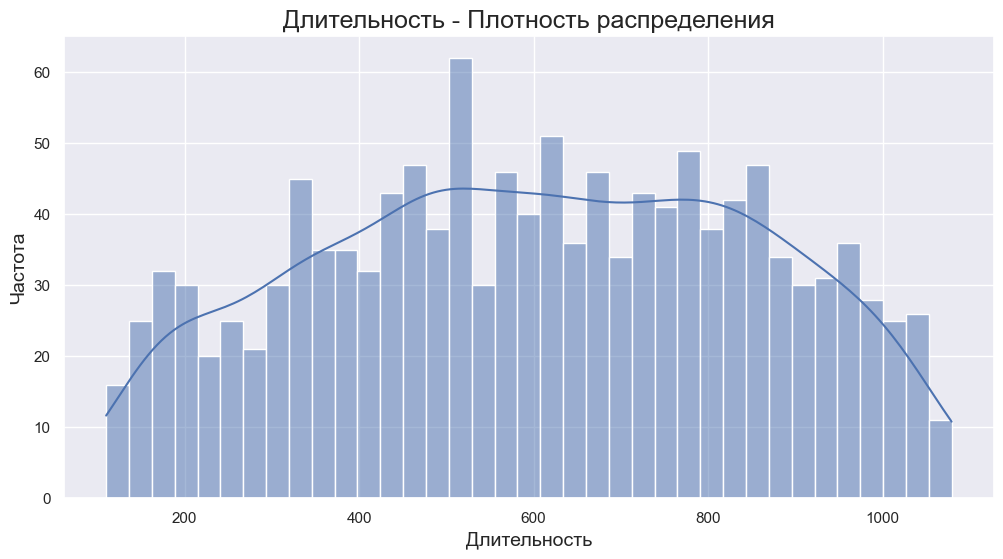

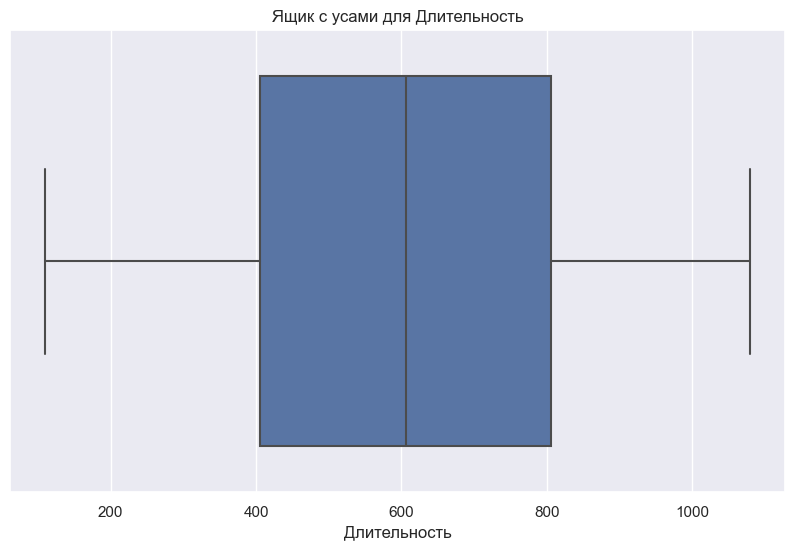

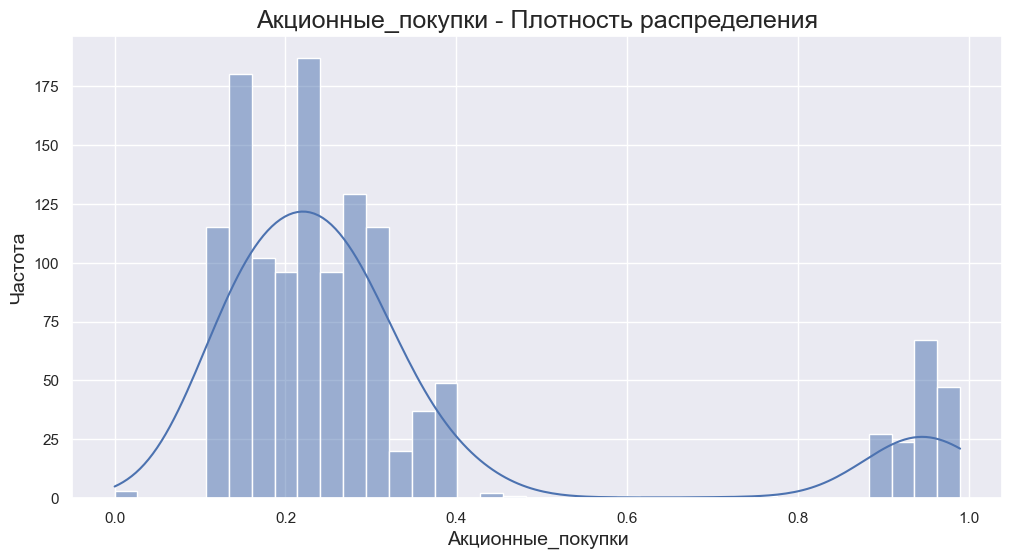

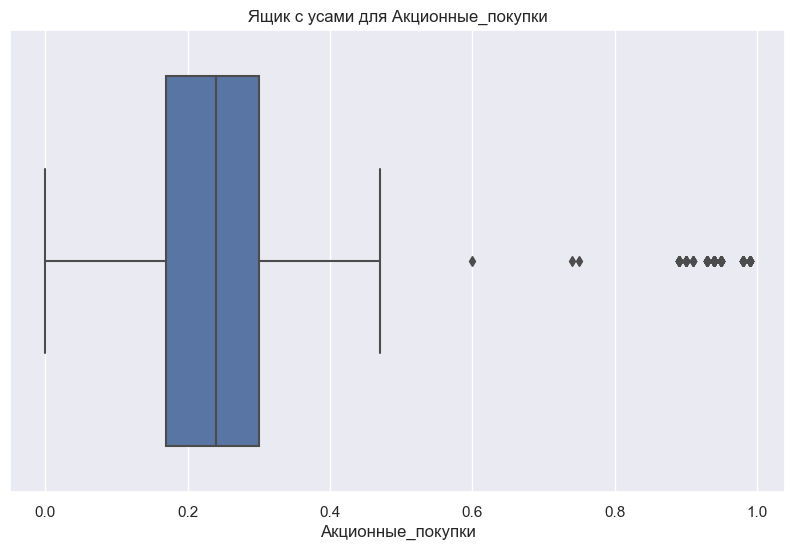

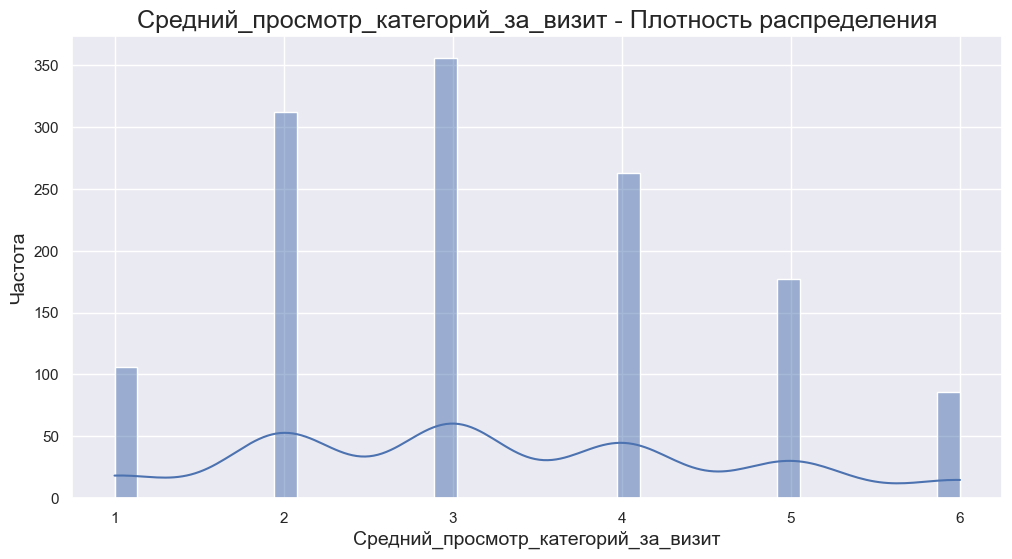

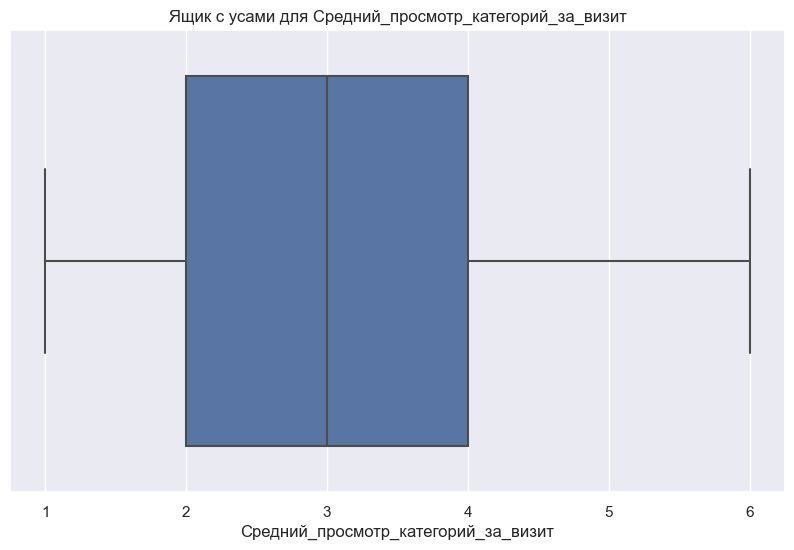

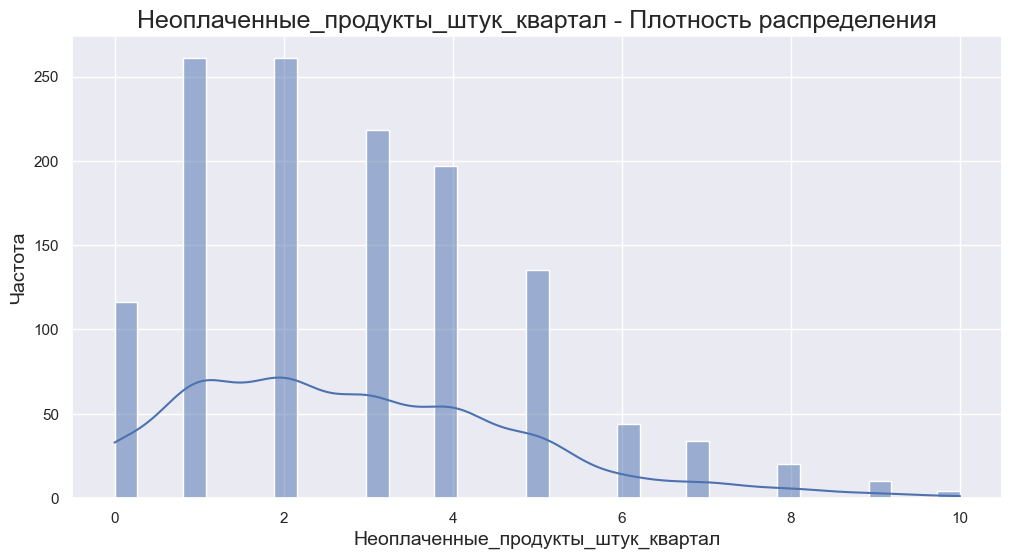

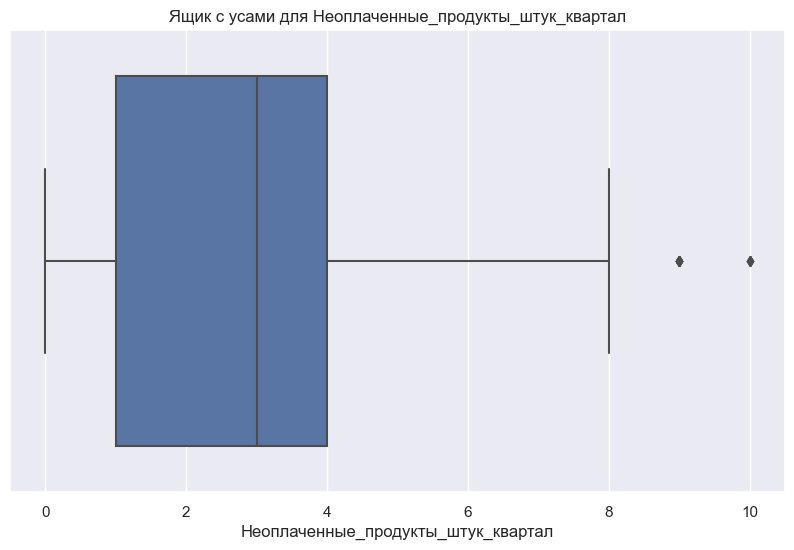

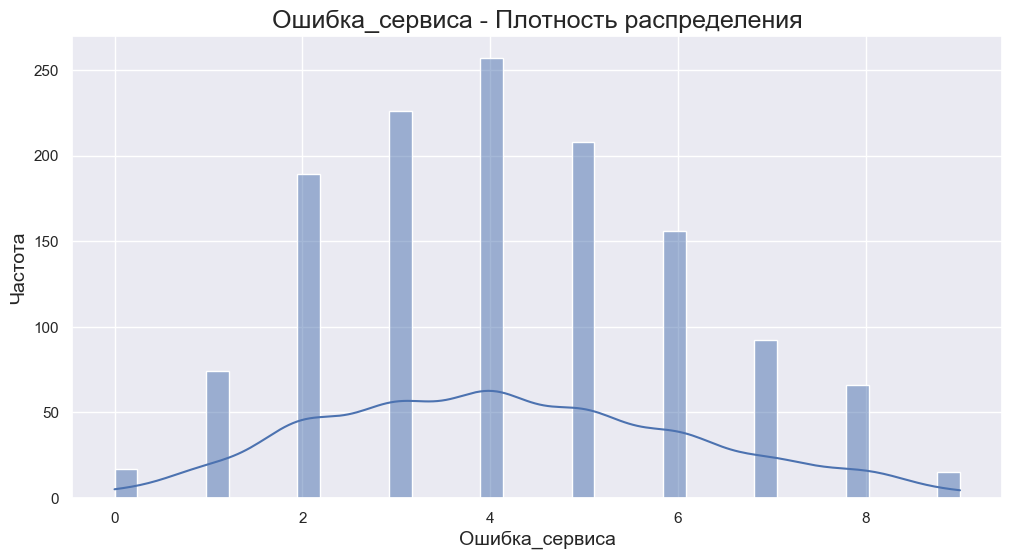

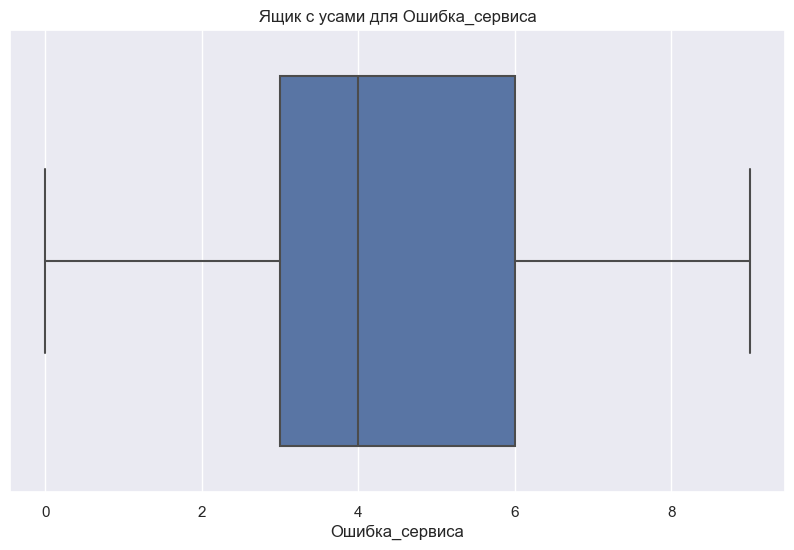

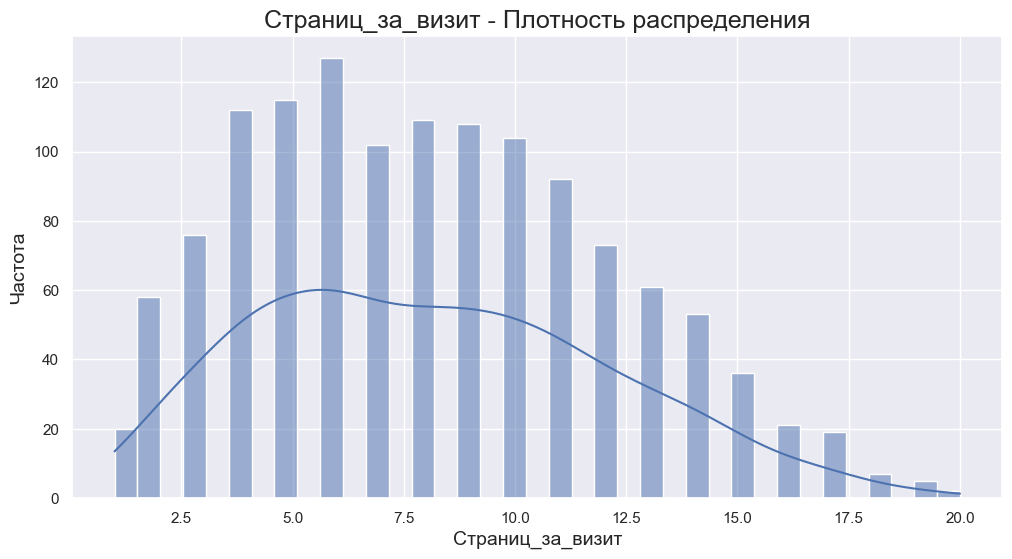

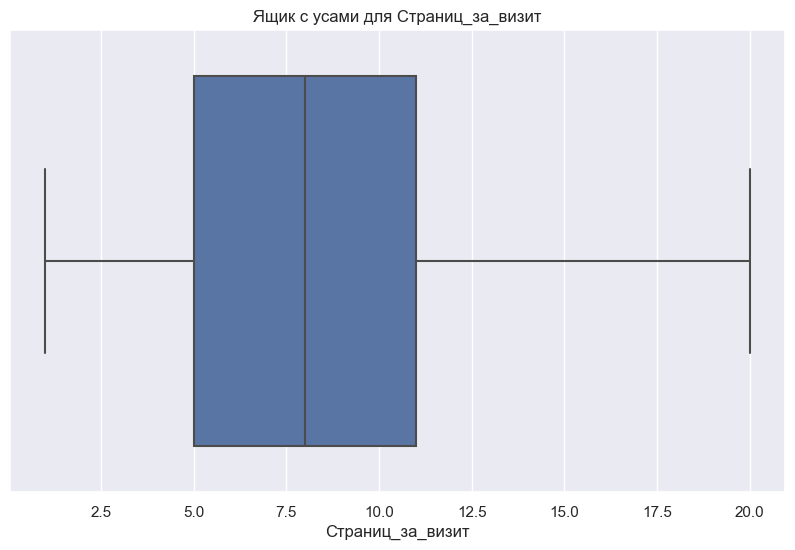

In [26]:
for num_name in num_col_names_market:
    create_histogram(df_market_file, num_name)
    create_boxplot(df_market_file, num_name)

На боксплотах видны выбросы. Избавимся от них

In [27]:
df_market_file = df_market_file[(df_market_file['Маркет_актив_6_мес'] >= 2)]
df_market_file = df_market_file[(df_market_file['Акционные_покупки'] <= 0.6)]
df_market_file = df_market_file[(df_market_file['Неоплаченные_продукты_штук_квартал'] <= 8)]


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Ну здесь всё отлично, понимающему человеку ясно, что здесь ты детально исследуешь столбцы-признаки наших наблюдений. Вижу гистограммы/графики, отрисовывающие "нумерические" столбцы.

Здесь идеально всё. Использование графиков для изучения данных - лучше и не пожелать способа. Молодец!
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Просто супер: график подписан, оси подписаны. Не часто на самом деле такой скрупулёзный подход к оформлению встречается. Молодец! Также, здорово, что есть объяснение поведения данного графика. Пытаться понять полученный результат - важная часть работы аналитика.

Я закончил физико-математический факультет Петрозаводского государственного университета. Нас там с первого курса приучили - если на сдачу лабораторной работы по физике приходишь с графиком, на котором не подписано общее название, названия осей (с единицами измерений), единичная шкала - всё сдача заканчивается не начавшись. Или если у моей лабораторной работы отсутствует вывод: что делали? по какой методике? что "намеряли"? как интерпретировали? какой финальный вывод? - всё, тоже на выход. Ну и в принципе сейчас, на текущей работе: код, который написан в тетрадке мало кому понятен и не сильно кому интересен. Важнее детальные выводы и тренды, которые попадут на слайд презентации в PowerPoint. Именно поэтому столь важное значение в аналитике данных придается промежуточным выводам и уж тем более финальному. 
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Совет - вместе с гистограммами следует использовать также и boxplot'ы ("ящики с усами" покажут и выбросы и основные статистики данных (квартили)). Почему гистограмму и ящик с усами надо использовать вместе? Первый хорошо показывает бимодальность, второй бимодальность не видит, но хорошо видит выбросы.
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Отлично! Боксплот рядом с гистограммой - это отлично! Гистограмма будет показывать нам распределение количественного признака, а боксплот даст информацию о выбросах и основных статистиках (квартидях) признака.
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>
    
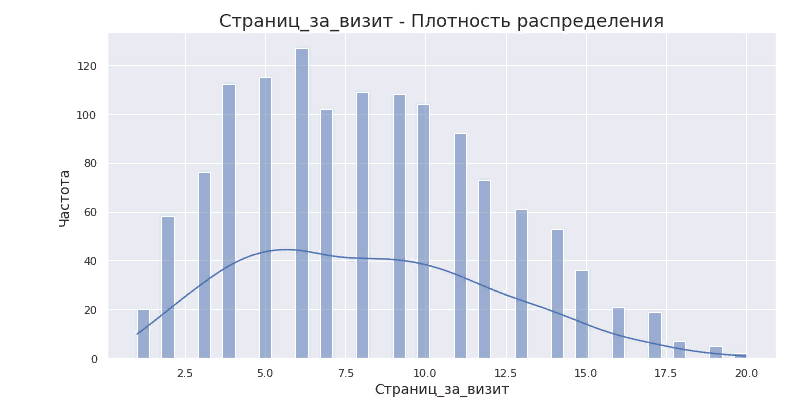    

1. Провалы в значениях гистограммы реально существуют? Или они появляются ввиду ошибочно выбранного значения bins?

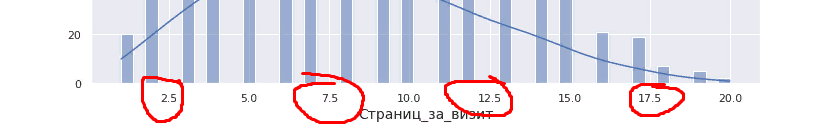    
    
2. Можно просмотреть столько страниц?    
    
---
Есть ряд техник, которые позволяют "плюс/минус" определиться с числом бинов:
    
1. правило Стёрджеса: число bins равно log2(n) + 1, где n - количество наблюдений
    
2. Правило Квиксола: количество интервалов (bins) близко к квадратному корню из числа наблюдений.    
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> 
    Да, я нашла выбросы с помощью боксплота. Чисто теоретически посмотреть половину страницы можно, если сайт фиксирует до какого момента была пролистана страница или через сколько секунд пользователь перешел на другую страницу. Но да, это не наш случай)) у меня все равно не получилось исправить на графике эти половинчатые значения для просмотра страниц, я использовала 2 стратегии и все равно не вышло
    </font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

1. Молодец что пробовала!
    
2. (Заметка на будущее): формат подписей по оси ОХ можно поправить так: 
    
* Определить, в виде массива numpy, то, что мы хотим видеть в виде подписей по ОХ, например: **ticks = np.arange(0, 21, 2)**, 
    
* Далее, передать в Матплотлибовскую функцию рисования параметр: **xticks=ticks**

</div>

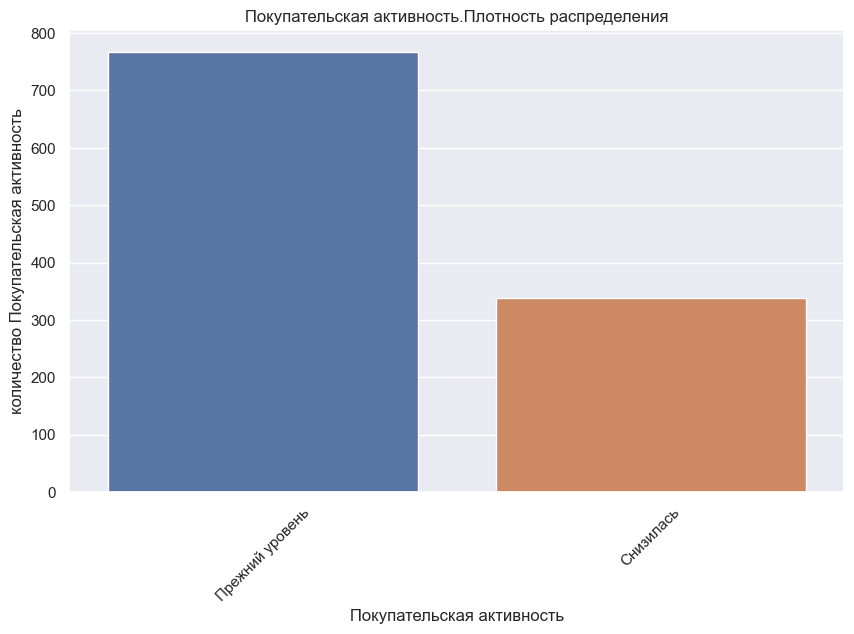

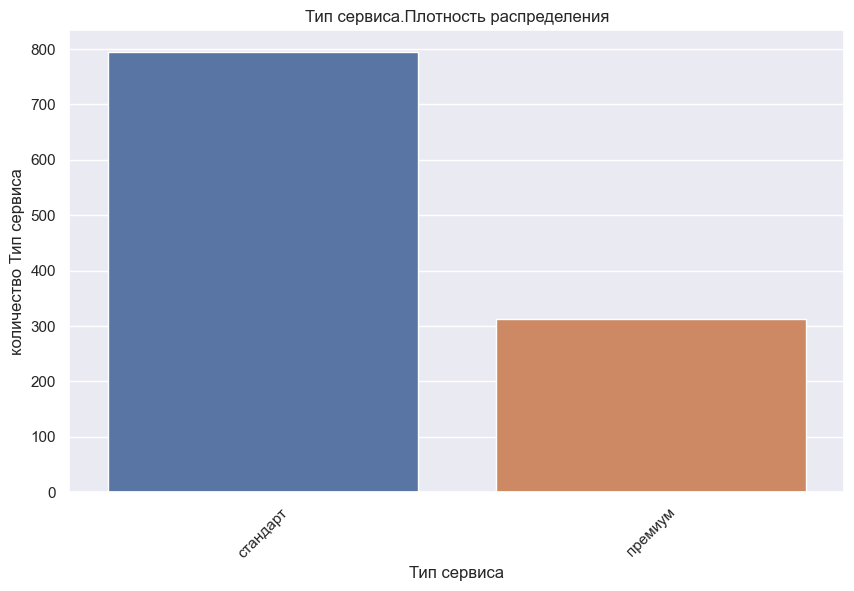

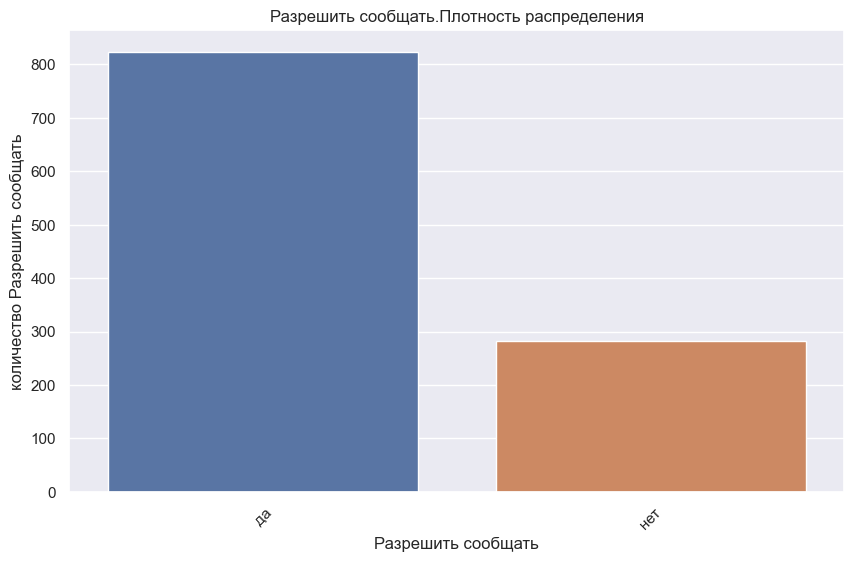

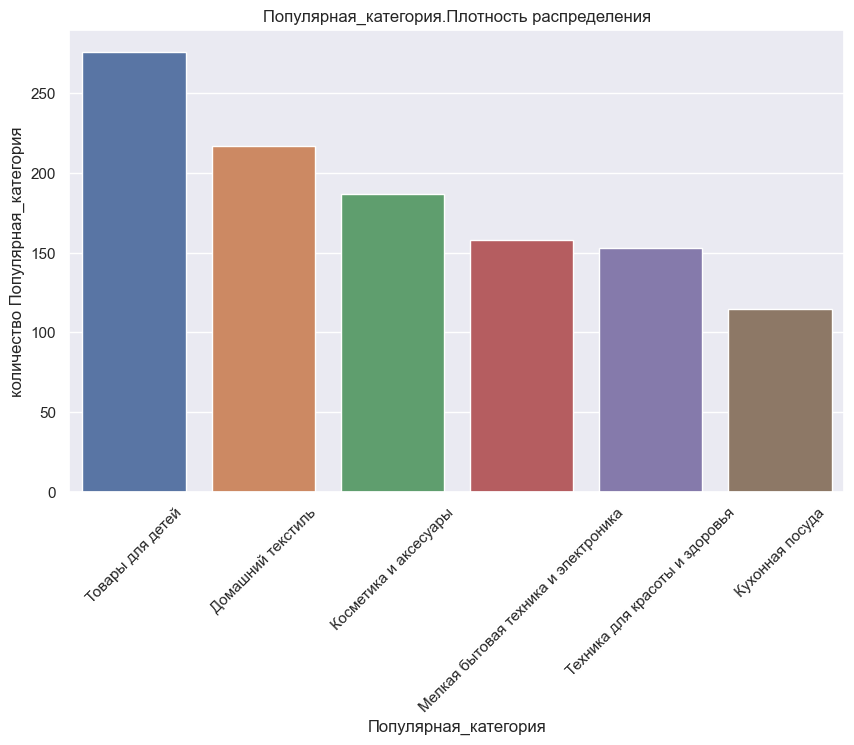

In [28]:
for cat_name in cat_col_names_market:
    create_barplot(df_market_file, cat_name)

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Наблюдаешь ли дисбаланс в целевой переменной (таргете)? Если наблюдаешь, то как этот факт отражается на выборке метрики для моделей МО?
</div>

 ### Проведем исследовательский анализ данных df_market_money

In [29]:
df_market_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [30]:
num_col_names_market_money, cat_col_names_market_money = cat_num_col(df_market_money)

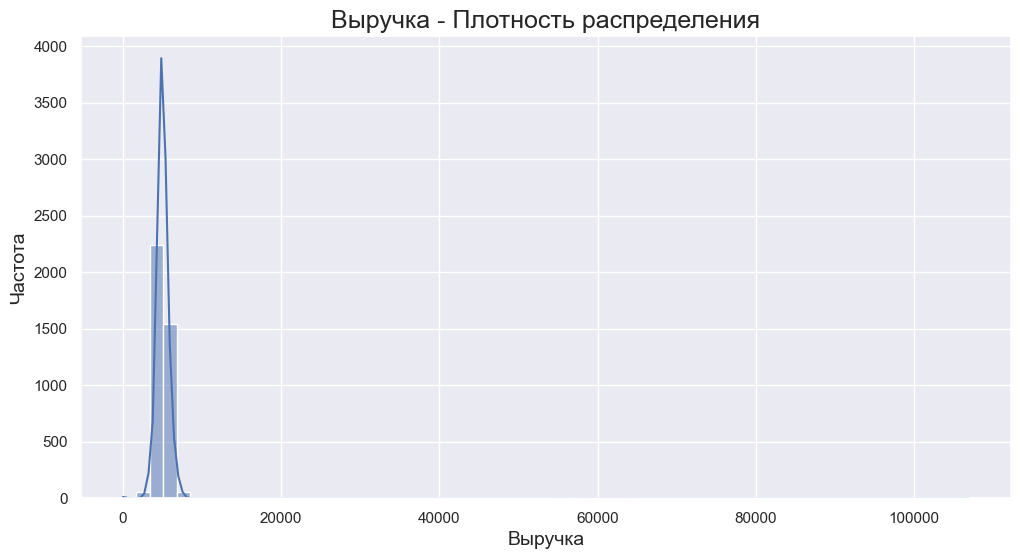

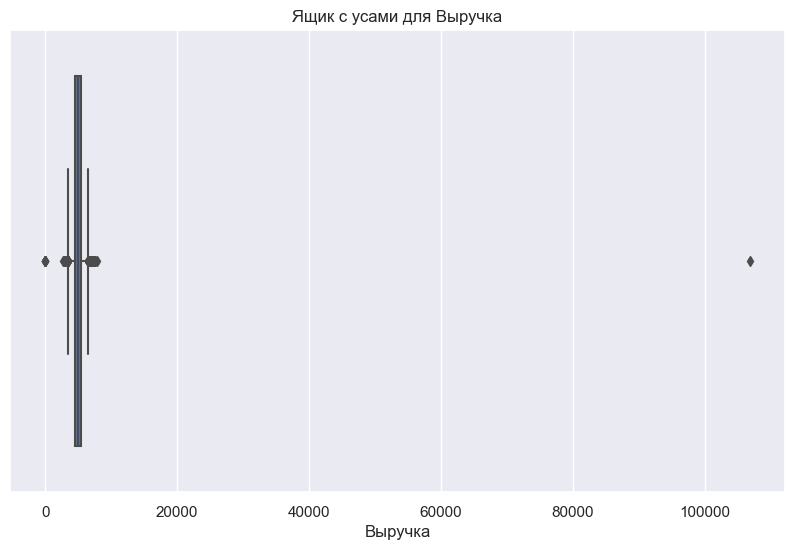

In [31]:
for num_name in num_col_names_market_money:
    create_histogram(df_market_money, num_name)
    create_boxplot(df_market_money, num_name)

Здесь имеется явный выброс. Избавимся от него 

In [32]:
df_market_money = df_market_money[(df_market_money['Выручка'] <= 6500) & 
                                  (df_market_money['Выручка'] >= 3500) ]


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, выброс удален!</div>

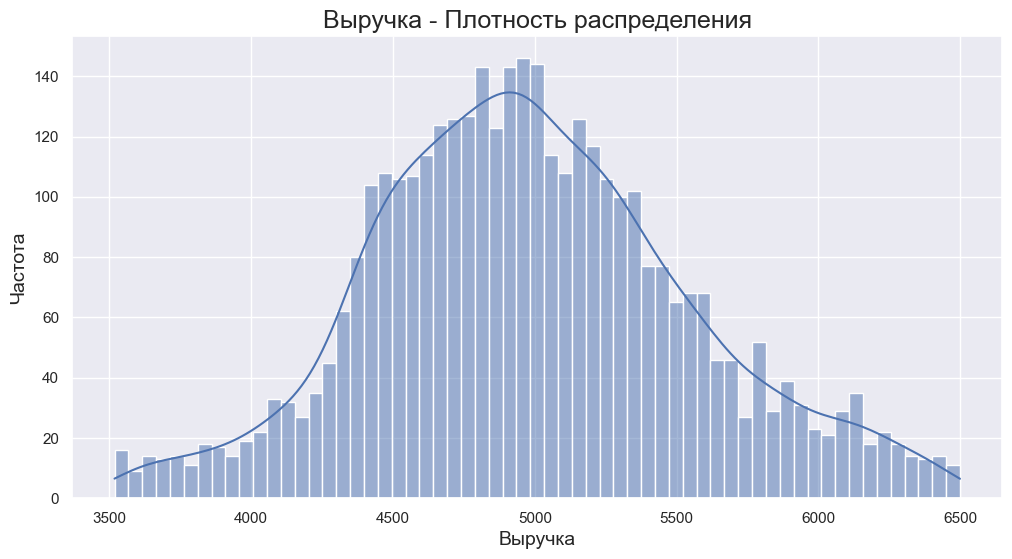

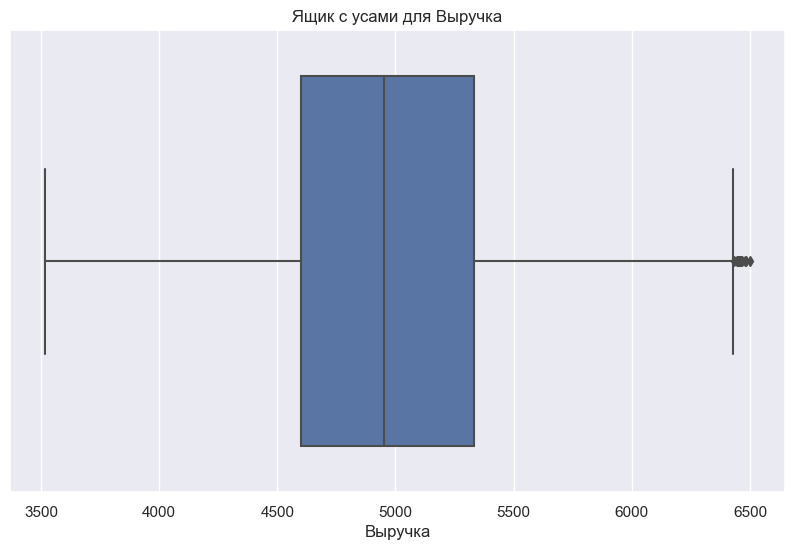

In [33]:
for num_name in num_col_names_market_money:
    create_histogram(df_market_money, num_name)
    create_boxplot(df_market_money, num_name)

 ### Проведем исследовательский анализ данных df_market_time

In [34]:
df_market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [35]:
num_col_names_market_time, cat_col_names_market_time = cat_num_col(df_market_time)

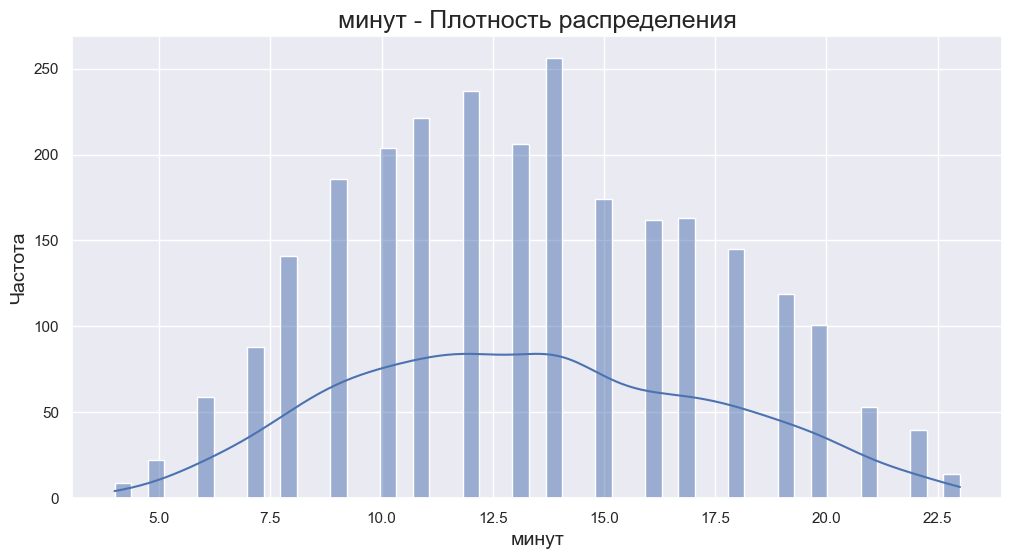

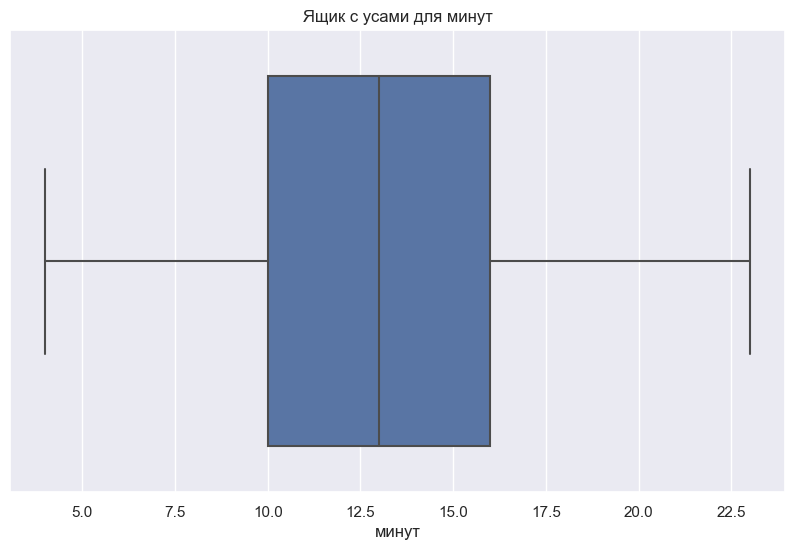

In [36]:
for num_name in num_col_names_market_time:
    create_histogram(df_market_time, num_name)
    create_boxplot(df_market_time, num_name)

### Вывод 
Удалили выбросы при необходимости 

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

К этому моменту в проекте всё ОК: необходимые после загрузки данных действия (1. требования PEP8, 2. дубликаты, 3. аномалии, 4. анализ уникальных значений в признаках, 5. пропуски) выполнены. Этот вывод результат твоей работы описывает и подъитоживает. Здесь всё супер, молодец!

</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Данные загружены, отлично.

Хорошо, что применяешь метод .head()/.sample() таким образом в память не будет загружен весь датасет, объем которого может быть огромным.

Методы .info, .describe, .value_counts(), .unique() как правило часто встречаются и обязательны к применению в задачах по исследованию данных, ведь с их помощью можно получить первые инсайты. 

Итак, мы провели предварительный анализ данных, проверили данные на наличие пропусков и затем обработали их (аргументированно заполнили / удалили / оставили как есть). Теперь можно приступать собственно к анализу данных и ответам на вопросы проекта.

У тебя крутой и мощный EDA. Детальнейшая обработка данных. С графиками. С рассуждениями. Молодец, всё классно в этом разделе.

</div>

# Этап 4. Объединение таблиц

<a id="step_04"></a>

Нам нужно отобрать покупателей с покупательской активностью не менее трех месяцев. Для этого нужно, чтобы данные о прибыли были за все 3 месяца. Поэтому план действий такой 
1) Сделать сводную таблицу по выручке за все 3 месяца из датафрейма df_market_money
2) Сделать сводную таблицу по выручке за все 2 месяца из датафрейма df_market_time. Это необходимо, чтобы при дальнейшем объединеннии у нас не образовалось строк с одинаковыми данными, кроме колонок периода на сайте в разные месяцы 
3) Объединить сводные таблицы с df_market_file
4) Удалить тех покупателей, у которых есть пропуски в одной из колонок прибыли за 3 месяца 

In [37]:
df_pivot_money = df_market_money.pivot(index='id', columns='Период', values='Выручка')
df_pivot_money.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,NaN
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


In [38]:
df_pivot_time = df_market_time.pivot(index='id', columns='Период', values='минут')

In [39]:
df_pivot_time.head()

Период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [40]:
df_pivot_time = df_pivot_time.rename(columns={
    'текущий_месяц': 'минут_за_текущий_месяц',
    'предыдущий_месяц': 'минут_за_предыдущий_месяц'
})

In [41]:
df_pivot_money = df_pivot_money.rename(columns={
    'текущий_месяц': 'выручка_за_текущий_месяц',
    'предыдущий_месяц': 'выручка_за_предыдущий_месяц',
    'препредыдущий_месяц': 'выручка_за_препредыдущий_месяц'
})


In [42]:
merged_df = df_market_file.merge(df_pivot_money, on='id', how='left')

In [43]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1106 entries, 0 to 1105
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1106 non-null   int64  
 1   Покупательская активность            1106 non-null   object 
 2   Тип сервиса                          1106 non-null   object 
 3   Разрешить сообщать                   1106 non-null   object 
 4   Маркет_актив_6_мес                   1106 non-null   float64
 5   Маркет_актив_тек_мес                 1106 non-null   int64  
 6   Длительность                         1106 non-null   int64  
 7   Акционные_покупки                    1106 non-null   float64
 8   Популярная_категория                 1106 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1106 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1106 non-null   int64  
 11  Ошибка_сервиса                

In [44]:
merged_df = merged_df.merge(df_pivot_time, on='id', how='left')

In [45]:
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
3,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
4,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,NaN,4749.0,3772.6,12,10


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Есть, отлично! Из "длинного" датафрейма сделали "широкий". Ровно то, что и требуется:
    
</div>

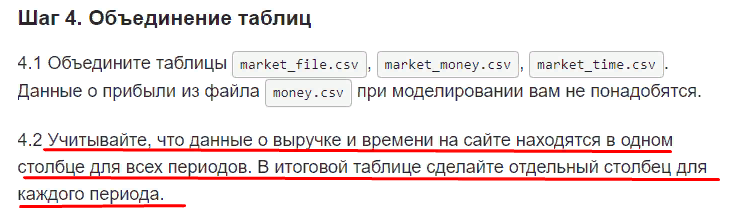

<div class="alert alert-warning">
<b>Комментарий 👉</b>

В случае объединения/слияния датафреймов рекомендую тебе смотреть на размерости датафреймов ДО слияния и ПОСЛЕ него. В подобных операциях часто ошибки бывают.
</div>

In [46]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1106 entries, 0 to 1105
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1106 non-null   int64  
 1   Покупательская активность            1106 non-null   object 
 2   Тип сервиса                          1106 non-null   object 
 3   Разрешить сообщать                   1106 non-null   object 
 4   Маркет_актив_6_мес                   1106 non-null   float64
 5   Маркет_актив_тек_мес                 1106 non-null   int64  
 6   Длительность                         1106 non-null   int64  
 7   Акционные_покупки                    1106 non-null   float64
 8   Популярная_категория                 1106 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1106 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1106 non-null   int64  
 11  Ошибка_сервиса                

In [47]:
merged_df.duplicated().sum()

0

In [48]:
merged_df.isna().sum()

id                                       0
Покупательская активность                0
Тип сервиса                              0
Разрешить сообщать                       0
Маркет_актив_6_мес                       0
Маркет_актив_тек_мес                     0
Длительность                             0
Акционные_покупки                        0
Популярная_категория                     0
Средний_просмотр_категорий_за_визит      0
Неоплаченные_продукты_штук_квартал       0
Ошибка_сервиса                           0
Страниц_за_визит                         0
выручка_за_предыдущий_месяц             40
выручка_за_препредыдущий_месяц           3
выручка_за_текущий_месяц               111
минут_за_предыдущий_месяц                0
минут_за_текущий_месяц                   0
dtype: int64

In [49]:
merged_df = merged_df.dropna()
merged_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
выручка_за_предыдущий_месяц            0
выручка_за_препредыдущий_месяц         0
выручка_за_текущий_месяц               0
минут_за_предыдущий_месяц              0
минут_за_текущий_месяц                 0
dtype: int64

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Супер! Здесь молодец, НЕ УПУСКАЕШЬ требование брифа в части обработки покупателей НЕ имеющих полной покупательской истории в крайние 3 месяца:
    
</div>

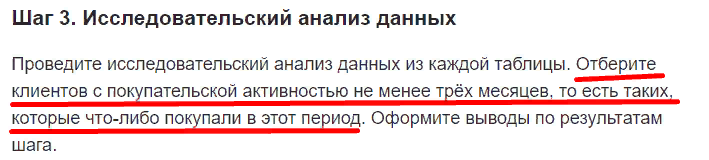

# Этап 5. Корреляционный анализ

<a id="step_05"></a>

Перед выполнением корреляционного анализа сделаем Шапиро тест на проверку нормальности распределения. Если хотя бы у одного признака не будет нормального распределения - в качестве корреляционного анализа будем использовать тест Спирмена 

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Есть, отлично(!), понимание нелинейности (или - не нормальности ... здесь употребляю НЕ как синонимы!) данных дает нам основание использовать метод Спирмена/Кендалла, а не Пирсона (при оценки степени корреляции признаков).
</div>

In [50]:
num_col, cat_col = cat_num_col(merged_df)
for col_name in num_col:
    shapiro_test(merged_df, col_name)
    print()

Результат теста Шапиро-Уилка для столбца Маркет_актив_6_мес:
Статистика теста: 0.9857491254806519
p-значение: 4.2208480266481274e-08
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Маркет_актив_тек_мес:
Статистика теста: 0.8055174946784973
p-значение: 1.5202161507245852e-32
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Длительность:
Статистика теста: 0.9704698324203491
p-значение: 4.0535202147987115e-13
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Акционные_покупки:
Статистика теста: 0.9578028321266174
p-значение: 4.415865451282814e-16
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Средний_просмотр_категорий_за_визит:
Статистика теста: 0.9332465529441833
p-значение: 2.2287761219781916e-20
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Неоплаченные_продукты_штук_квартал:
Статистика теста:

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>	

Да, всё верно. "Строго" нормальность распределения данных доказывается статистическим тестом.
</div>

In [51]:
merged_df_low = merged_df[merged_df['Покупательская активность'] == 'Снизилась']
merged_df_previous = merged_df[merged_df['Покупательская активность'] == 'Прежний уровень']

Посмотрим на корреляционный анализ для данных, где покупательская активность снизилась

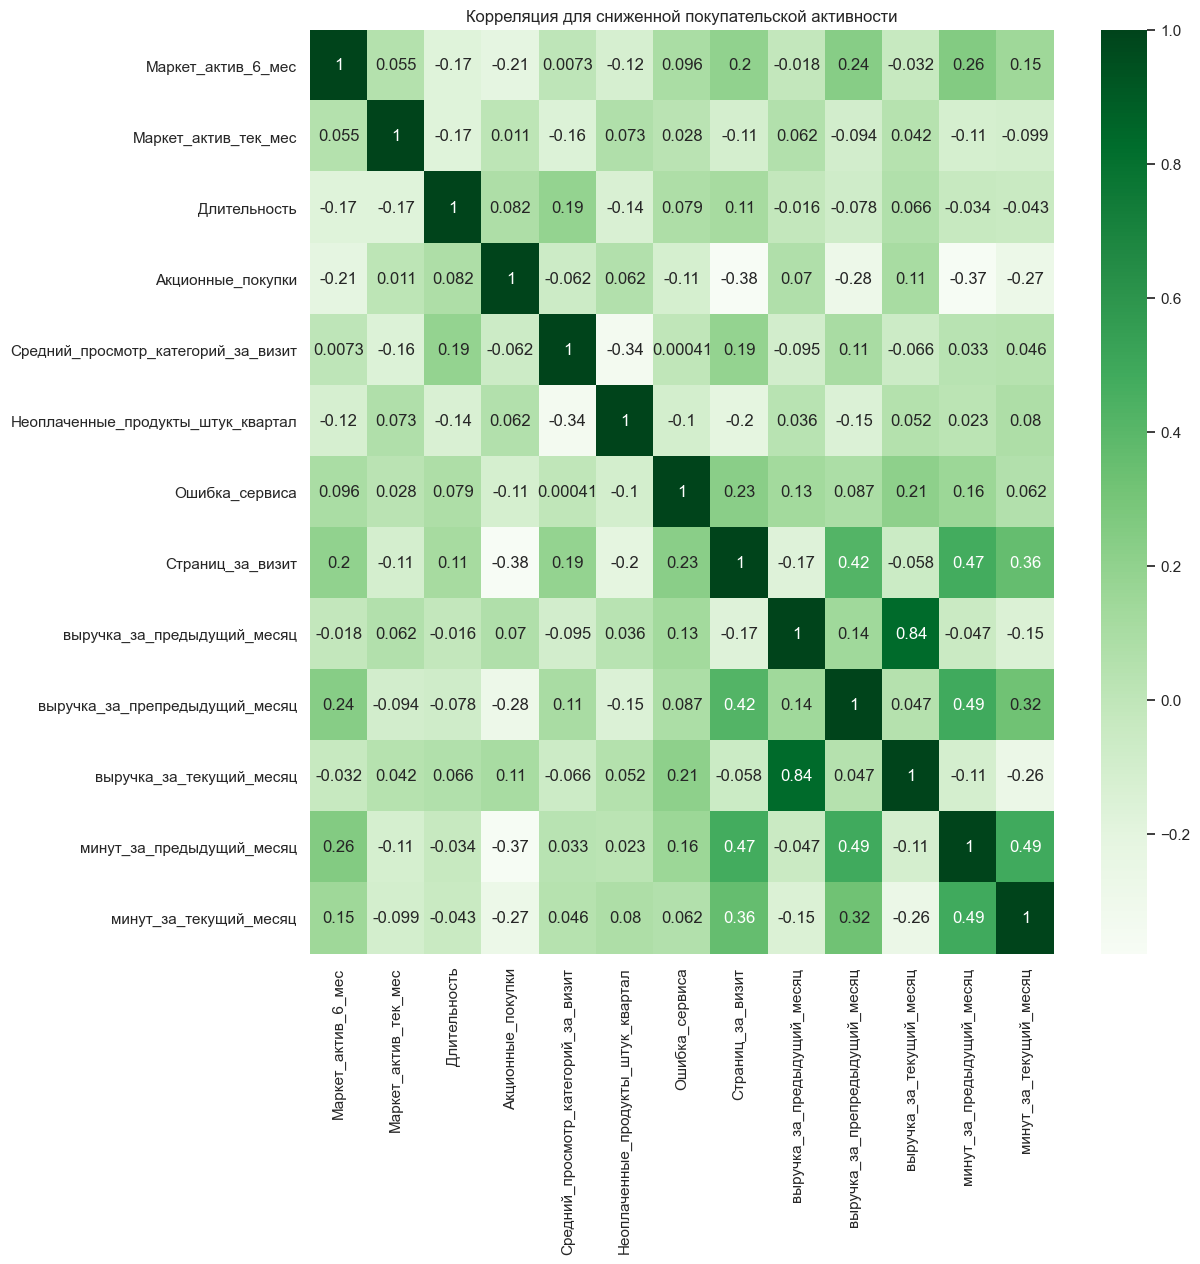

In [52]:
corr = merged_df_low[num_col].corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('Корреляция для сниженной покупательской активности')
sns.heatmap(corr, annot = True, cmap="Greens")
None

Посмотрим на корреляционный анализ для данных, где покупательская активность осталась на прежнем уровне

<AxesSubplot:title={'center':'Корреляция для покупательской активности на прежнем уровне'}>

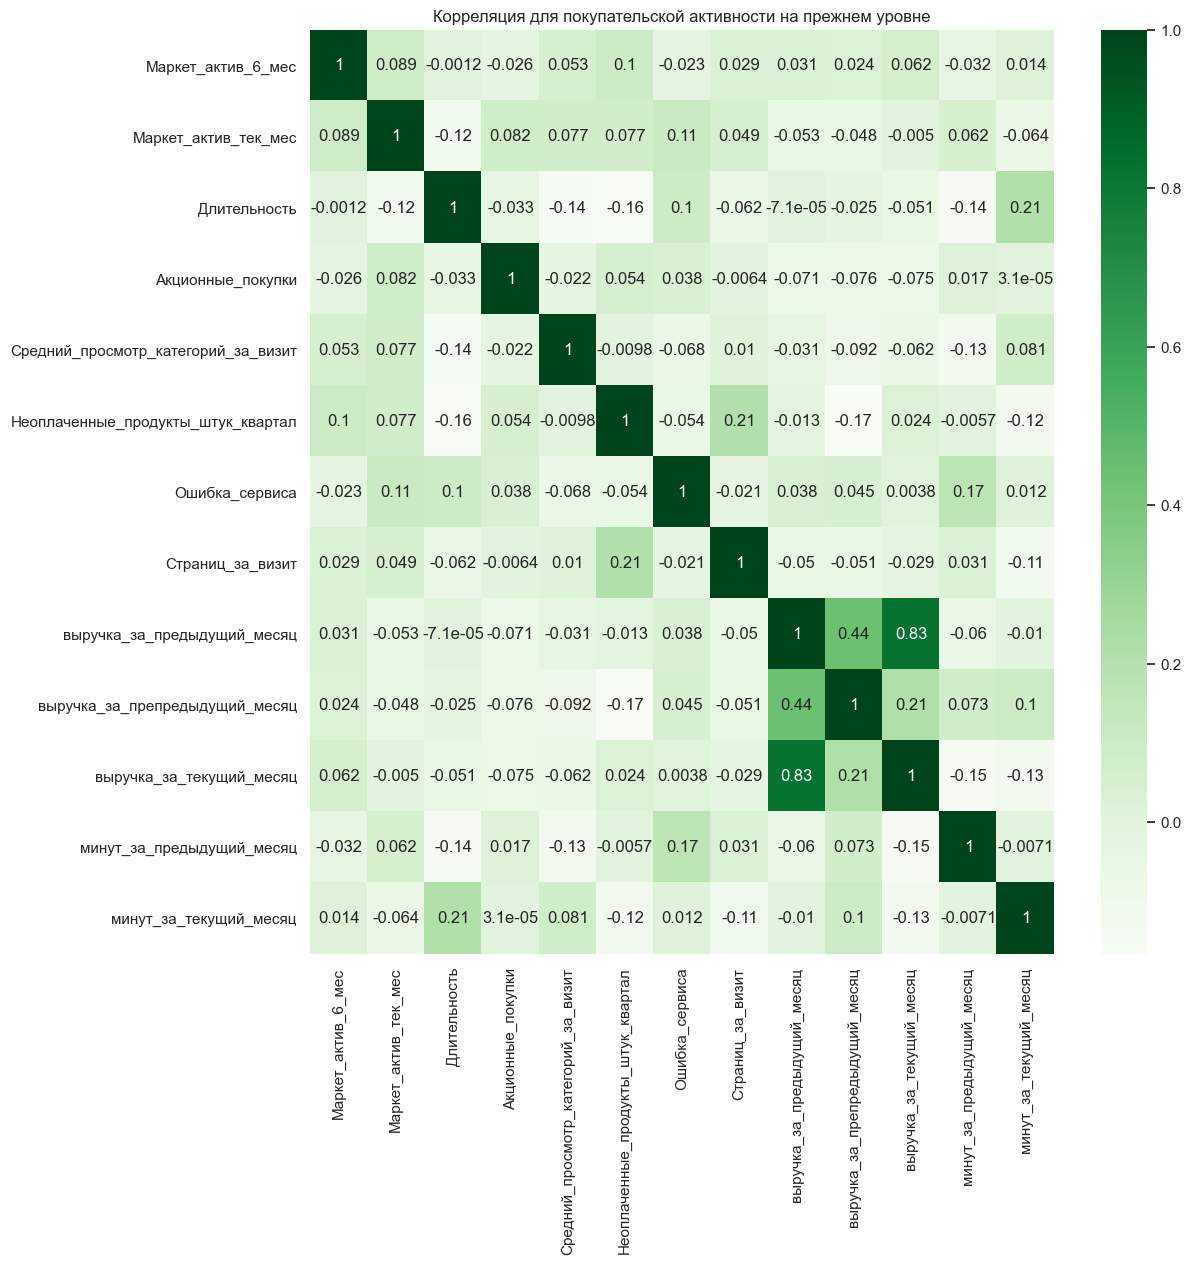

In [53]:
corr = merged_df_previous[num_col].corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('Корреляция для покупательской активности на прежнем уровне')
sns.heatmap(corr, annot = True, cmap="Greens")

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Смотришь скоррелированность признаков - отлично! Об этом чуть ниже подробней напишу....

---
p.s. присмотрись к библиотеке phik! Она (Phi_K correlation) представляет собой инструмент для вычисления и визуализации корреляции между категориальными и количественными переменными. Она может быть полезной в анализе данных перед построением моделей машинного обучения, так как позволяет обнаружить скрытые взаимосвязи между переменными, которые могли бы остаться незамеченными при обычных методах корреляционного анализа.
Преимущества использования **phik**:

1. **Учет категориальных переменных**: Традиционные методы вычисления корреляции, такие как коэффициент корреляции Пирсона, применяются только к количественным переменным. phik позволяет вычислять корреляцию между категориальными и количественными переменными, что делает его мощным инструментом для анализа разнообразных типов данных.

2. **Обнаружение нелинейных зависимостей**: phik способен обнаруживать нелинейные связи между переменными, которые могли бы быть упущены традиционными методами. Это особенно важно в анализе данных, где зависимости могут быть сложными и нелинейными (что может влиять на твой выбор признаков для моделей МО).

3. **Подходит для больших наборов данных**: phik обладает хорошей масштабируемостью, что позволяет использовать его для анализа больших наборов данных без серьезного снижения производительности.

4. **Визуализация результатов**: Библиотека предоставляет инструменты для визуализации матрицы корреляции между переменными, что помогает лучше понимать зависимости в данных.

Вот пример кода, как использовать phik для вычисления корреляции:
    
    import phik
    import pandas as pd

    # Загрузка данных
    data = pd.read_csv('data.csv')

    # Вычисление матрицы корреляции с использованием phik
    corr_matrix = data.phik_matrix()

    # Визуализация матрицы корреляции
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Phi_K Correlation Matrix')
    plt.show()

p.s. у этой библиотеки есть ограничение с которым я например сталкивался: когда в даных есть столбцы с очень большим количеством уникальных значений, то phik может "упасть" с сообщением об ошибке (суть которого в том, что не хватает памяти для обработки такого количества "уников"). ПРи этом на компьютере у меня 32 Гб памяти и большая часть её не занята. Я подозреваю что это некое внутреннее ограничение библиотеки.
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

В задаче классификации, когда в данных несколько классов (как у нас: "активность снизилась" и "активность преждняя"), то настоятельно рекомендую корреляционный анализ (с визуализацией и расчетом коэффициентов) проводить отдельно для каждого класса!!! Если это делать на данных одновременно для 2х (и более классов - такие могут быть ситуации), то "картинка может быть смазанной"! Очень легко НЕ УВИДЕТЬ взаимосвязи присущие тому или иному классу.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Исправила</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Есть! Вижу анализ признаков и/или коэффициентов корреляции по каждому из классов в наших данных!
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Несколько моментов "на будущее" (сейчас забегаю чуть вперед, но будущем это будет важно) которые я хотел озвучить перед переходом к собственно исследованию (некоторые из этих моментов в твоем проекте реализованы):
    
- имеет смысл критично посмотреть на данные с точки зрения наличия пропусков в признаках (вопрос: все ли ml-модели "любят" пропуски?) и обработать или удалить их 
    
- имеет смысл явно обозначить какую задачу мы будем решать: с учителем / без учителя, классификации / регрессии ...
    
- в моделях бинарной классификации (если бы это был бы наш случай!) имеет смысл смотреть на баланс классов. Два взгляда (с разных сторон) на эту проблему тут: https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/ и https://habr.com/ru/post/349078/
    
- имеет смысл смотреть на корреляцию признаков. При высокой их степени коррелированности возникает проблема  мультиколлиниарность признаков. Проблема "мультиколлинеарности" это и про переобучение модели и про её интерпретируемость и про сложность модели (содержание в модели избыточного количества переменных). В чем негативный эффект сложной модели? Вот в чем: усложняется интерпретация параметров, оценки параметров ненадежны – получаются большие стандартные ошибки, которые меняются с изменением объема наблюдений, что делает модель регрессии непригодной для прогнозирования.

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>Подробнее ...</u></summary>

Вот несколько причин, почему проблема мультиколлинеарности (МК) важна:

1. Неоднозначность коэффициентов: МК делает оценку коэффициентов модели неустойчивой. Когда существует сильная корреляция между признаками, модель становится неспособной разделить влияние каждого признака на целевую переменную. Это может привести к неоднозначным и неправильным оценкам коэффициентов, что затрудняет интерпретацию важности каждого признака. Согласись - это важно, чтобы результат, который выдает модель можно было бы понять и объяснить с точки зрения предметной области. В случае включения в модель высокоскоррелированных признаков - может случиться так, что коэффициенты (да, проблема присуща моделям линейным ... регрессия среди них!) могут менять знаки и попытка объяснения предметной области с помощью этих коэффициентов будет противоречить здравому смыслу.

2. Плохая обобщающая способность: МК может снизить способность модели обобщаться на новые данные. Когда сильно коррелированные признаки присутствуют в модели, модель может стать "перегенерированной" и склонной к переобучению на обучающих данных. В результате модель может показывать хорошую производительность на обучающих данных, но плохо обобщаться на новые данные.

3. Ухудшение точности и устойчивости модели: МК может привести к численным проблемам при решении линейных уравнений, используемых для оценки коэффициентов модели. Это может привести к нестабильности и неточности оценок. Кроме того, небольшие изменения в данных могут привести к большим изменениям в оценках коэффициентов модели, что делает модель неустойчивой.

4. Избыточность информации: Когда признаки сильно коррелированы, они предоставляют практически одинаковую информацию о целевой переменной. Такая избыточность может привести к неэффективности модели и увеличению сложности модели без значительного улучшения производительности.

В целом, МК может иметь отрицательное влияние на производительность, стабильность, интерпретируемость и обобщающую способность.
    
---
Для деревянных моделей и моделей градиентного бустинга проблема МК  не является такой критической, как для линейных моделей. Вот несколько причин:

1. Нелинейность: Деревянные модели и модели градиентного бустинга являются нелинейными моделями. Они способны обрабатывать сложные взаимодействия между признаками и целевой переменной. В отличие от линейных моделей, они могут более гибко адаптироваться к наличию мультиколлинеарности в данных.

2. Рекурсивное разбиение: Деревья принятия решений в деревянных моделях и моделях градиентного бустинга используют рекурсивное разбиение для разделения данных на более чистые группы. Это означает, что деревья могут независимо выбирать разные признаки для разделения, даже если они сильно коррелированы. Таким образом, деревья могут игнорировать мультиколлинеарность и использовать другие признаки для принятия решений.

3. Ансамбль деревьев: Модели градиентного бустинга строятся на основе ансамбля слабых деревьев решений. Каждое дерево добавляется постепенно для уменьшения ошибки предыдущих деревьев. Это позволяет модели градиентного бустинга восстанавливать ошибки, вызванные мультиколлинеарностью, поэтапно улучшая прогнозы.

Хотя мультиколлинеарность не является проблемой в деревянных моделях и моделях градиентного бустинга в той же степени, что и в линейных моделях, она все еще может оказывать влияние на производительность и интерпретируемость модели. Сильно коррелированные признаки могут вносить избыточность в модель и увеличивать сложность, не принося значительного улучшения в прогнозах. Поэтому, хотя деревья могут быть более устойчивыми к мультиколлинеарности, все же рекомендуется выполнять анализ корреляции признаков и, при необходимости, применять методы снижения размерности или регуляризации для улучшения модели.
    
Вот классная статья. Простым языком, на примере показана проблема. А также, что важно - разобраны варианты как её (проблему) победить. Статья: https://habr.com/ru/company/akbarsdigital/blog/592493/ 
    
</details>
<br>
<br>    
</div>

### Вывод 
По нашим данным мультиколлинеарности не обнаружено 

# Этап 6: Пайплайн 

<a id="step_06"></a>

Напишем пайплан. Следующий план действий

1) Разделение данных на обучающую и тестовую выборки, с установкой размера тестовой выборки (25%) и заданием стратификации для сохранения баланса классов.
2) Подготовка преобразований для категориальных признаков (OneHotEncoder) и порядковых признаков (OrdinalEncoder) с использованием операций замещения отсутствующих значений (SimpleImputer).
3) Создание трансформера данных, который объединяет преобразования признаков, включая масштабирование числовых признаков с использованием StandardScaler.
4) Создание пайплайна, включающего предварительную обработку данных и модель (DecisionTreeClassifier).
5) Определение сетки параметров для различных моделей, включая DecisionTreeClassifier, LogisticRegression, SVC и KNeighborsClassifier.
6) Использование RandomizedSearchCV для поиска лучших параметров моделей с целью максимизации метрики roc_auc на тренировочной выборке.
7) Обучение лучшей модели на обучающих данных и оценка ее производительности на тестовых данных с выводом лучших параметров, метрики лучшей модели на тренировочной выборке и метрики ROC-AUC на тестовой выборке.

In [54]:

merged_df['Покупательская активность'] = merged_df['Покупательская активность'].apply(lambda x: 0 if x == 'Снизилась' else (1 if x == 'Прежний уровень' else x))


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Обрати внимание на ячейку, которую я сейчас комментирую – видишь слайдер («бегунок») снизу? Он показывает, что код не помещается в видимые границы ячейки (и чтобы его полностью «прочитать» - нужно использовать мышь. Код очень длинный.

Код очень длинный (а PEP8 определяет длину строки в 79 символов) - попробуй длинные - переносить, а между строками использовать пустые строки. Ну и желательно код комментировать, хотя бы коротко (что делаешь и каков будет результат - так твоим коллегам будет проще за твоей мыслью следить). Этот комментарий может относиться к нескольким ячейкам этой «тетрадки».

Хороший разработчик форматирует и комментирует свой код, тогда другие разработчики быстрее разберутся в программе. Это важно, ведь код чаще читают, чем пишут: напишет один, а прочтут — сотни или тысячи (если код хороший). 
«Пишите код так, как будто сопровождать его будет склонный к насилию психопат, который знает, где вы живете.» ©1991, John F. Woods, разработчик

---
Давай обсудим стиль кодирования (программирования)? Смотри что сейчас происходит в этой ячейке (**не всё применимо к твоему коду здесь, но я попытался собрать и представить здесь самые ценные советы из PEP8 по организации кода**) и что можно сделать по-другому, чуть лучше:

1. Комментарии к строке кода: они должны располагаться выше соответствующей строки кода (выше строки к которой относятся) и должны быть от этой строки отделены пустой строкой. Если же они расположены справа, то для того чтобы увидеть, что там написано приходится пользоваться скроллиногом. Надо добиться того, чтобы ячейку не приходилось прокручивать, т.к. это не добавляет удобства ни при отладке кода, ни для понимания что в этой ячейке "происходит". Как альтернатива – комментарий может размещаться выше, в Markdown-ячейке.
    
2. Бывает, что встречаются очень длинные строки кода, которые также уходят за правый край ячейки. Такие строки должны разбиваться разделителем (вот таким: \\). Это best practice, требование PEP8, а именно: PEP8 определяет длину строки в 79 символов.
    
3. **В идеале**: одна ячейка - одна строка кода. Почему так? Да как минимум из соображения понятности: будучи выполненной, под этой ячейкой должен отображаться результат трансформации данных. Ты или твой коллега должны видеть, как поменялись данные после выполнения ячейки с кодом. Следующая ячейка - ещё строка кода и соответствующим output'ом. Будешь делать так - коллеги будут тебе благодарны за то, что легко будут следовать за твоей мыслью. И отладку это упрощает. Ну и как противоположность - можно в одну ячейку "положить" результат 3-х последовательных groupby + ещё чего-нибудь. Разобраться с ходу "что происходит" будет очень трудно, придётся всё равно код разносить по ячейкам и смотреть последовательно что происходит. Но ведь логично это делать удобным способом сразу, ведь так?
    
4. Неиспользуемые, закомментированные строки выше вынеси в другую ячейку, отдельную, выше. Можешь для удобства своего прокомментировать (на память). И оставь там это код, так, чтобы он не смешивался с рабочим кодом.

p.s. возможно и в следующих ячейках твоей «тетрадки» будет код, который просмотреть можно только используя мышку, но я этот момент более комментировать не буду – просто обращай внимание на слайдер под ячейкой с кодом.
</div>

In [55]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
    merged_df.drop(['Покупательская активность', 'id'], axis=1),
    merged_df['Покупательская активность'],
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify = merged_df['Покупательская активность']
)
matrix =   merged_df.drop(['Покупательская активность', 'id'], axis=1)
ohe_col = ['Популярная_категория']
ord_col = ['Тип сервиса', 'Разрешить сообщать']

<div class="alert alert-warning">
<b>Комментарий 👉</b>

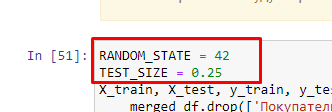    
    
Обычно я set'ы, настройки и константы также размещаю в ячейке с импортами, в её конце. Пример скрина моего текущего рабочего проекта:

</div>

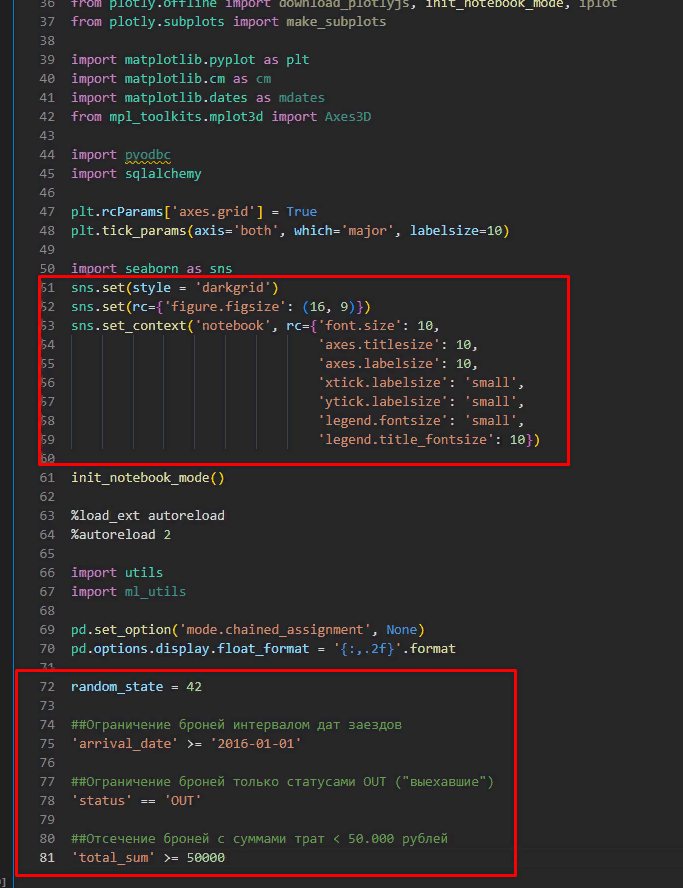

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

1. Здесь хорошо, происходит фиксация random_state. Воспроизводимость результатов разбиения выборки на обучающую (тренировочную) / тестовую мы обеспечили, значит при всех последующих запусках нашего кода подвыборки будут идентичными.
    
2. Доли размеров train/test 3:1 - хорошо.

3. Молодец что используешь параметр stratify. Использование stratify позволит сохранить баланс меток классов 1/0 ("снизится"/"не снизится") в 2х выборках (этот момент важен **особенно** в случае сильного дисбаланса классов в данных). Но конечно stratify это "не про" решение проблемы с "выравниванием" количества строк (с определенным классом) именно в данных.
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Я бы рекомендовал после разбиения данных на выборки посмотреть на их **размеры и размерности**. Метод shape для этого - идеальный помощник. "Цифры" по выборкам покажут верно ли мы произвели "разделение" данных.

p.s. так (**псевдокод**): X_train.shape[0] – «покажет» количество строк в тренировочной выборке, а X_train.shape[1] - количество столбцов в ней же. Ну а X_train.shape – выведет размерность train'а в виде кортежа с 2мя значениями (первое число – количество строк, второе – столбцов).</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Исключительно как вариант, а также воспользоваться советом со Стэковерфлоу: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213

	train, valid, test = np.split(df.sample(frac=1, random_state=821), [int(.6*len(df)), int(.8*len(df))])

Также, разбивать данные можно и автоматизировано, используя библиотеку fast_ml (см. скрин). К этому скрину один комментарий – не факт, что эта библиотека fast_ml развернута здесь, на Хабе, НО дома, своей локальной машине, с установленной средой (например Анакондой: https://www.anaconda.com/products/distribution) ты вполне можешь этим вариантом пользоваться (после установки **!pip install fast_ml**):
</div>

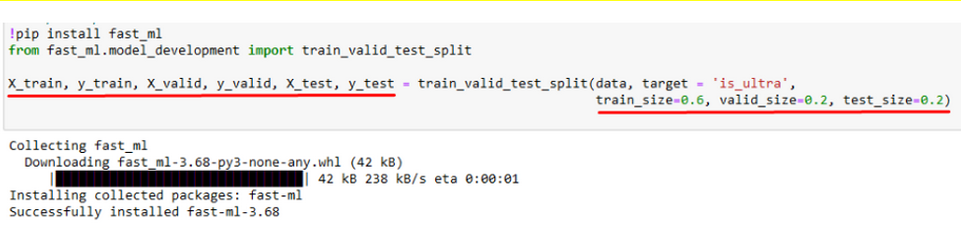

In [56]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)

ord_pipe = Pipeline([
    (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
    ), 
    (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

<div class="alert alert-warning">
<b>Комментарий 👉</b>

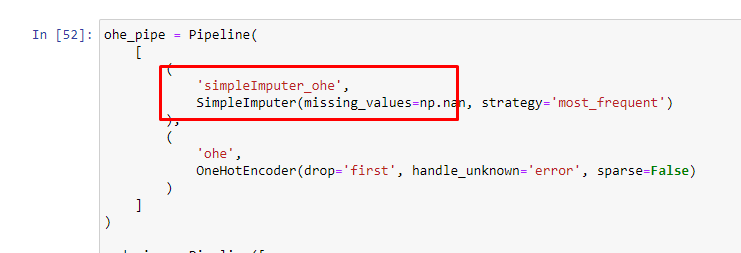
    
Есть пропуски у нас в данных?
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Использование трансформеров и пайплайнов - СУПЕР!
    
---
Преимущества использования трансформеров:

1. **Гибкость и модульность**: Трансформеры позволяют разбить сложные операции по предобработке данных на более мелкие и легко управляемые компоненты. Это делает код более читаемым и модульным.

2. **Переиспользование**: Трансформеры могут быть повторно использованы на разных этапах анализа данных и построения моделей. Например, ты можешь создать трансформер для нормализации данных и использовать его как в обучении модели, так и на этапе инференса.

3. **Работа с разными типами данных**: Трансформеры могут обрабатывать различные типы данных, включая текст, изображения и числовые значения. Это позволяет тебе создавать единые интерфейсы для предобработки разнообразных данных.

Преимущества использования пайплайнов:

1. **Структурированность**: Пайплайны помогают организовать последовательность шагов обработки данных, начиная с загрузки и заканчивая подготовкой к обучению модели. Это обеспечивает структурированность и позволяет легко вносить изменения.

2. **Поддержание кода**: Пайплайны сокращают вероятность ошибок и упрощают поддержание кода. Отслеживание последовательности операций делает процесс отладки и оптимизации более прозрачным.

3. **Масштабируемость**: Пайплайны могут быть легко расширены новыми этапами обработки данных. Это позволяет добавлять новые операции без переписывания всего кода.

Объединение трансформеров и пайплайнов позволяет создавать чистые, структурированные и гибкие рабочие процессы для подготовки данных. Например, ты можешь создать трансформеры для преобразования текстовых данных и числовых значений, а затем построить пайплайн, который последовательно применяет эти трансформеры и завершается обучением модели. Это существенно упростит управление и анализ данных перед обучением моделей машинного обучения.

Несколько ссылок, которые позволят погрузиться в тему:

- [трансформеры](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) и [пайплайны](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) для организации предобработки (кодирования, масштабирования) и модели
- применение пайплайна [A Basic Introduction to Pipelines in Scikit Learn](https://towardsdatascience.com/a-basic-introduction-to-pipelines-in-scikit-learn-bd4cee34ad95)
- большой гайд как можно комбинировать разные этапы предобработки [Pipelines and composite estimators](https://scikit-learn.org/stable/modules/compose.html)
- или можно написать свой класс-трансформер [Custom Transformers and Pipelines in Python](https://towardsdatascience.com/custom-transformers-in-python-part-ii-6fe111fc82e4)
</div>
</div>

Например, для модели DecisionTreeClassifier определяем гиперпараметры max_depth, min_samples_split, и min_samples_leaf, которые контролируют глубину дерева, минимальное количество образцов для разделения внутреннего узла и минимальное количество образцов в листе соответственно. Эти параметры позволяют настраивать уровень детализации и предотвращать переобучение модели.

Для модели LogisticRegression определяем гиперпараметр C, который регулирует силу регуляризации, а также был выбран предпроцессор preprocessor__num, представляющий набор различных методов нормализации данных для тщательного сравнения и оптимизации модели.

Для модели SVC определяем гиперпараметры, таких как C, kernel, gamma и degree, которые влияют на тонкую настройку модели опорных векторов в многомерном пространстве. Эти параметры позволяют модели гибко определять разделяющие гиперплоскости, что важно для точности классификации.

Для модели KNeighborsClassifier определяем гиперпараметр n_neighbors, который определяет количество соседей, учитываемых при классификации.

В качестве метрики выбираем ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) - это метрика, которая позволяет оценить качество бинарной классификации модели. Она представляет собой площадь под кривой ROC и измеряет способность модели разделять классы путем сравнения вероятностей. Чем выше значение ROC-AUC, тем лучше модель различает между положительным и отрицательным классами.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Есть, ОТЛИЧНО! Вижу обоснование выбора и использования конкретной ml-метрики в твоем проекте!
    
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Хочу этот момент дополнительно прокомментировать: метрики F1 и ROC-AUC - это два разных способа оценки качества моделей машинного обучения, и они измеряют разные аспекты модели. Вот их основные отличия:

1. F1-мера (F1 Score): Измеряет точность и полноту модели. Эта метрика помогает оценить способность модели правильно классифицировать положительные и отрицательные примеры. F1-мера является хорошим выбором, когда у нас есть дисбаланс классов.

2. ROC-AUC (Receiver Operating Characteristic - Area Under the Curve): Оценивает способность модели различать между классами. Он измеряет площадь под ROC-кривой, которая показывает отношение между долей верно классифицированных положительных и долей ложноположительных результатов при изменении порогового значения.

**Сфера применения:**

1. F1-мера: Часто используется в задачах с несбалансированными классами, таких как поиск аномалий, обнаружение мошенничества, медицинские диагнозы и другие задачи, где важна точность классификации положительных примеров.
    
2. ROC-AUC: Чаще используется в задачах бинарной классификации для оценки способности модели разделять классы, независимо от баланса классов.
    
**Зависимость от порога:**

1. F1-мера: Чувствительна к выбору порогового значения для классификации. Она не учитывает ROC-кривую и не зависит от порога.

2. ROC-AUC: Не зависит от конкретного порогового значения. Оценивает качество модели на всех возможных пороговых значениях и учитывает весь спектр чувствительности и специфичности.
    
В зависимости от конкретной задачи и целей оценки модели, ты можешь выбирать между этими метриками. Если тебе важна способность модели правильно классифицировать положительные и отрицательные примеры, то F1-мера может быть предпочтительной. Если твоя задача связана с разделением классов, то ROC-AUC может быть более подходящей метрикой.
    
Не изменил своего мнения по поводу нашей метрики?    
</div>

In [57]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 4, 5],
        'models__min_samples_split': range(1, 10),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 1, 10], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly'], 
        'models__gamma': [0.1, 1, 10],
        'models__degree': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

random_search.fit(X_train, y_train)
print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

pred = random_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred)}')

warnings.filterwarnings('ignore')

/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for t

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
               

### Вывод
На основании предоставленной информации, лучшая модель, полученная в результате обучения, является SVC (метод опорных векторов) с определенными параметрами:

* C (параметр регуляризации) равен 0.1
* degree (степень для ядра полинома) составляет 2
* gamma (коэффициент для ядра) равен 10
* ядро (kernel) установлено как линейное
* probability установлено как True
* random_state установлен на 42
* Метрика лучшей модели на тренировочной выборке составляет 0.8973, что указывает на высокую точность модели на обучающих данных. 
* Метрика ROC-AUC на тестовой выборке составляет 0.8468, что говорит о хорошей способности модели классифицировать тестовые данные.

<div class="alert alert-warning">
<b>Комментарий 👉</b>

**Метрика лучшей модели на тренировочной выборке составляет 0.8973, что указывает на высокую точность модели на обучающих данных** - Расчет метрик на train не "говорящий" показатель (на обучающей выборке заведомо будет завышенный показатель, так как ты обучаешь и тестируешь на одних и тех же данных). 
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Раздел - СУПЕР! Пайплайны, транфсофрмеры - современный технологичный способ упаковки кода моделей и подбора ГП. Метрика проекта также выбрана и её использование обосновано.
</div>

# Этап 7. Оценка важности признаков

<a id="step_07"></a>

Для оценки важности признаков нужно выполнить следующие действия 
1) Применить предварительную обработку данных к обучающей выборке X_train с помощью метода fit_transform пайплайна pipe_final.
2) Создать объект explainer с использованием бестселлера best_estimator_ из случайного поиска и получить модель с помощью метода named_steps['models']. Затем применить explainer к обработанной обучающей выборке X_train.
3) Применить предварительную обработку данных к тестовой выборке X_test с помощью метода transform пайплайна pipe_final.
Получить имена признаков с помощью get_feature_names_out из трансформера предварительной обработки и создать DataFrame X_test с этими именами.
4) Вычислить значения SHAP для X_test с помощью ранее созданного explainer.
5) Построить столбчатую диаграмму важности признаков с использованием shap.plots.bar и значениями SHAP, рассчитанными на шаге 5.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

О, shap используешь. СУПЕР. Редко его встречаю. Обычно feature_importances все оперируют. МОЛОДЕЦ!

---
Графики SHAP предоставляют визуальное объяснение влияния каждого признака на модель. Вот некоторые ключевые типы графиков SHAP и их интерпретация:

1. **Summary Plot (Общий график):**

* Главная цель этого графика - показать вклад каждого признака в прогнозы модели.
* График показывает каждый признак на оси X, где точка на графике представляет вклад этого признака в прогноз.
* Положительные значения указывают, что большее значение этого признака повышает прогноз, отрицательные - понижает.

2. **Force Plot (График силы влияния):**

* Позволяет увидеть, как каждый признак влияет на конкретный прогноз.
* Визуализирует SHAP-значения для каждого признака для определенной точки данных и как они влияют на прогноз.

3. **Dependence Plot (График зависимости):**

* Показывает взаимосвязь между значением конкретного признака и предсказанием модели.
* Позволяет увидеть, как меняется предсказание при изменении значения одного признака, при условии, что остальные признаки фиксированы.

4. **Waterfall Plot (График водопада):**

*Представляет изменения от базового прогноза до конечного прогноза для каждого наблюдения.

* Показывает влияние каждого признака на изменение прогноза относительно базового значения.

5. **Interaction Value Plot (График взаимодействия):**

* Позволяет увидеть, как взаимодействие между двумя признаками влияет на прогноз.
* Он показывает, как изменения значений двух признаков влияют на SHAP-значения.

Когда рассматриваешь графики SHAP, обрати внимание на направление и величину влияния каждого признака на прогноз. Положительные значения обычно повышают прогноз, отрицательные - понижают. Важно также анализировать взаимодействия между признаками и их зависимости от целевой переменной.
</div>

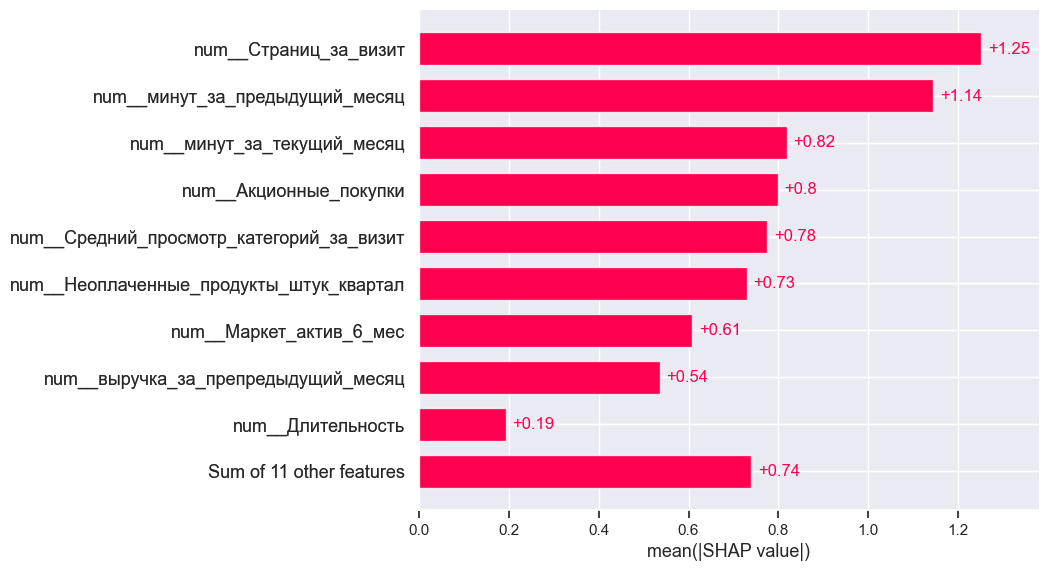

In [58]:
X_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.Explainer(random_search.best_estimator_.named_steps['models'], X_train)

X_test = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test = pd.DataFrame(X_test, columns =feature_names)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)




<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Молодец, здесь ты делаешь то, что я редко встречаю в этих проектах (я про визуализацию признаков, которые модель "посчитала" важными. Почему их анализ важен и полезен (несколько причин, почему важно тщательно "рассматривать" признаки):

1. **Информативность**: Признаки содержат информацию, которая помогает модели делать предсказания. Некоторые признаки могут быть более информативными, чем другие, и могут иметь сильное влияние на результаты модели. Понимание, какие признаки являются наиболее информативными, поможет сосредоточить усилия на сборе и анализе этих признаков, что в конечном итоге может привести к лучшим предсказаниям модели.

2. **Устранение шума и избыточности**: Некоторые признаки могут содержать шумовую или избыточную информацию, которая может негативно повлиять на работу модели. Анализ и отсев таких признаков помогут улучшить качество модели, устранить возможное переобучение и улучшить ее способность обобщать данные.

3. **Раскрытие взаимосвязей**: Изучение признаков может помочь обнаружить скрытые взаимосвязи и зависимости в данных. Например, два признака могут быть слабо информативными сами по себе, но в комбинации могут образовывать сильный предиктор. Исследование и понимание взаимосвязей между признаками может привести к созданию более сложных, но более мощных моделей.

4. **Сокращение размерности**: Некоторые наборы данных могут содержать большое количество признаков, и это может стать проблемой для обучения моделей. Сокращение размерности путем отбора наиболее важных признаков позволяет сократить вычислительную сложность, снизить вероятность переобучения и улучшить интерпретируемость модели.

5. **Интерпретируемость**: Понимание важности признаков также помогает интерпретировать результаты модели. Если мы знаем, какие признаки оказывают наибольшее влияние на предсказания, мы можем сделать более осознанные выводы и принимать меры на основе результатов   
</div>


In [59]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 1 to 1105
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Тип сервиса                          968 non-null    object 
 1   Разрешить сообщать                   968 non-null    object 
 2   Маркет_актив_6_мес                   968 non-null    float64
 3   Маркет_актив_тек_мес                 968 non-null    int64  
 4   Длительность                         968 non-null    int64  
 5   Акционные_покупки                    968 non-null    float64
 6   Популярная_категория                 968 non-null    object 
 7   Средний_просмотр_категорий_за_визит  968 non-null    int64  
 8   Неоплаченные_продукты_штук_квартал   968 non-null    int64  
 9   Ошибка_сервиса                       968 non-null    int64  
 10  Страниц_за_визит                     968 non-null    int64  
 11  выручка_за_предыдущий_месяц    

### Вывод 
Наиболее важные признаки - количество страниц за визит и проведенное время на сайте, акционные покупки, средний просмотр страниц за визит, количество маркетинговых коммуникаций в текущем месяце, неоплаченые покупки. А вот тип сервиса, разрешение рассылки и сколько дней прошло с момента регистрации покупателя на сайте мало значимы. 

На основе наиболее важных признаков модели, можно рассмотреть следующие маркетинговые стратегии для удержания покупателей:

1) Персонализированные рекомендации
2) Улучшение акционных предложений
3) Оптимизация маркетинговых коммуникаций
4)Работа с неоплаченными покупками

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Экспертный вывод по графикам! Не просто красивые картинки построены, но описаны те моменты, которые дата-сайентист видит в них!
</div>

# Шаг 8. Сегментация покупателей

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Сразу скажу, что в этом разделе ошибок быть не может ))) Всё потому, что грамотный и вдумчивый исследователь данных (*а ты собственно к этому моменту доказываешь, что визуализацией данных владеешь + видением трендов и закономерностей (на основе этих графиков) обладаешь*) - с почти 100%ой вероятностью **СМОЖЕТ** провести исследование групп покупателей, да и сделать конкретные предложения по работе с этими сегментами для увеличения профита Компании.
</div>

<a id="step_08"></a>

Для сегментации покупателей сделаем следующие действия:
1) Произведем фильтрацию данных. В датафрейме df_money оставим только тех, кто есть в merged_df
2) Сделаем предсказание вероятностей с помощью обученной модели random_search и добавление результатов в датафрейм df_segmentation
3) Сделаем построение scatter plot для анализа вероятности снижения и прибыльности
4) После выполним расчет матрицы корреляции и построение тепловой карты корреляции
5) Сделаем присвоение категорий в зависимости 

In [60]:
df_money= df_money[df_money['id'].isin(merged_df['id'])]
proba = random_search.predict_proba(matrix)
df_segmentation = df_money.copy()
df_segmentation['вероятность_снижения'] = proba[:, 0]
df_segmentation.head()

,id,Прибыль,вероятность_снижения
2,215350,3.13,0.336303
5,215353,3.95,0.653518
6,215354,3.62,0.714832
8,215356,4.93,0.896961
12,215360,4.55,0.606505


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 1000x600 with 0 Axes>

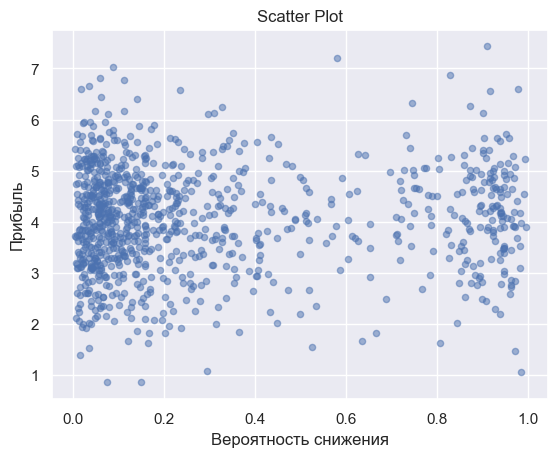

In [61]:
plt.figure(figsize=(10, 6))
df_segmentation.plot(x='вероятность_снижения', y='Прибыль', kind='scatter', alpha=0.5)
plt.title('Scatter Plot')
plt.xlabel('Вероятность снижения')
plt.ylabel('Прибыль')
plt.show()

In [62]:
shapiro_test(df_segmentation, 'вероятность_снижения')
print()
shapiro_test(df_segmentation, 'Прибыль')

Результат теста Шапиро-Уилка для столбца вероятность_снижения:
Статистика теста: 0.7822659015655518
p-значение: 5.261551285188945e-34
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Прибыль:
Статистика теста: 0.997707188129425
p-значение: 0.20075556635856628
Распределение данных является нормальным.


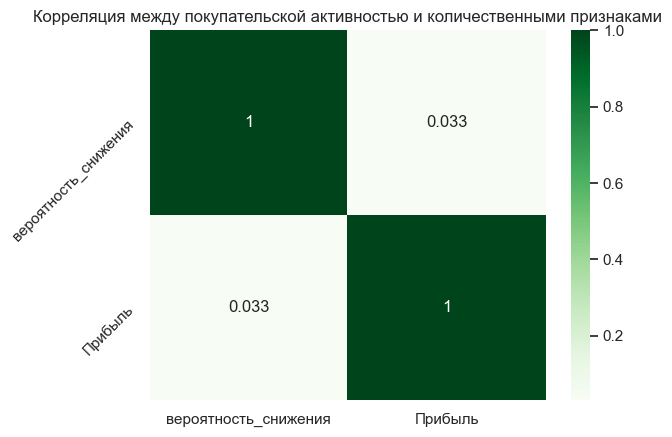

In [63]:
correlation_matrix = df_segmentation[['вероятность_снижения', 'Прибыль']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='Greens')
plt.yticks(rotation=45)
plt.title(f'Корреляция между покупательской активностью и количественными признаками')
plt.show()


По анализу корреляции и scatter plot можно сделать вывод, что между прибылью от покупателя и вероятностью снижения покупательской активности нет зависимости. 
Поэтому выберем покупателей, у которых высокая прибыль и высокая вероятность снижения покупательской активности и для них подберем стратегии. 

In [64]:
df_segmentation.describe()

,id,Прибыль,вероятность_снижения
count,968.000000,968.000000,968.000000
mean,216057.393595,4.048037,0.300379
std,355.707078,1.014244,0.316703
min,215350.000000,0.860000,0.003839
25%,215779.750000,3.380000,0.062074
50%,216073.500000,4.100000,0.152555
75%,216359.250000,4.740000,0.432703
max,216646.000000,7.430000,0.996172


In [65]:
df_segmentation['категория'] = 'остальные' 
condition = (df_segmentation['Прибыль'] > 4) & (df_segmentation['вероятность_снижения'] > 0.7)
df_segmentation.loc[condition, 'категория'] = 'категория 1'
df_segmentation = df_segmentation[df_segmentation['категория'] != 'остальные']
df_reserch = df_segmentation.merge(merged_df, on='id', how='inner')
df_reserch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 0 to 109
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   110 non-null    int64  
 1   Прибыль                              110 non-null    float64
 2   вероятность_снижения                 110 non-null    float64
 3   категория                            110 non-null    object 
 4   Покупательская активность            110 non-null    int64  
 5   Тип сервиса                          110 non-null    object 
 6   Разрешить сообщать                   110 non-null    object 
 7   Маркет_актив_6_мес                   110 non-null    float64
 8   Маркет_актив_тек_мес                 110 non-null    int64  
 9   Длительность                         110 non-null    int64  
 10  Акционные_покупки                    110 non-null    float64
 11  Популярная_категория            

In [66]:
df_reserch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 0 to 109
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   110 non-null    int64  
 1   Прибыль                              110 non-null    float64
 2   вероятность_снижения                 110 non-null    float64
 3   категория                            110 non-null    object 
 4   Покупательская активность            110 non-null    int64  
 5   Тип сервиса                          110 non-null    object 
 6   Разрешить сообщать                   110 non-null    object 
 7   Маркет_актив_6_мес                   110 non-null    float64
 8   Маркет_актив_тек_мес                 110 non-null    int64  
 9   Длительность                         110 non-null    int64  
 10  Акционные_покупки                    110 non-null    float64
 11  Популярная_категория            

In [67]:
cat_reserch = ['Популярная_категория', 'Разрешить сообщать']
num_reserch = ['Страниц_за_визит', 'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц', 'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал']

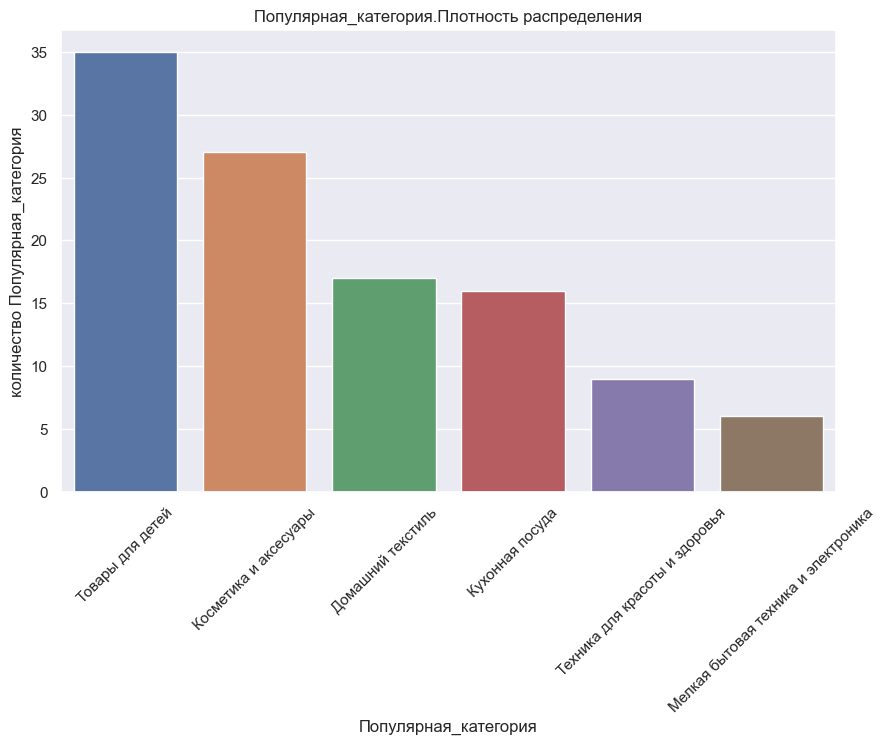

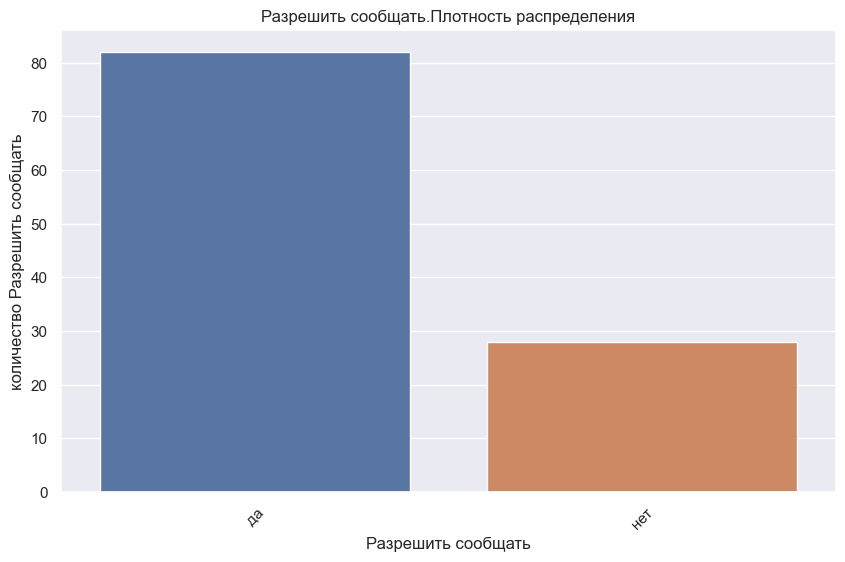

In [68]:
for cat in cat_reserch:
    create_barplot(df_reserch, cat)

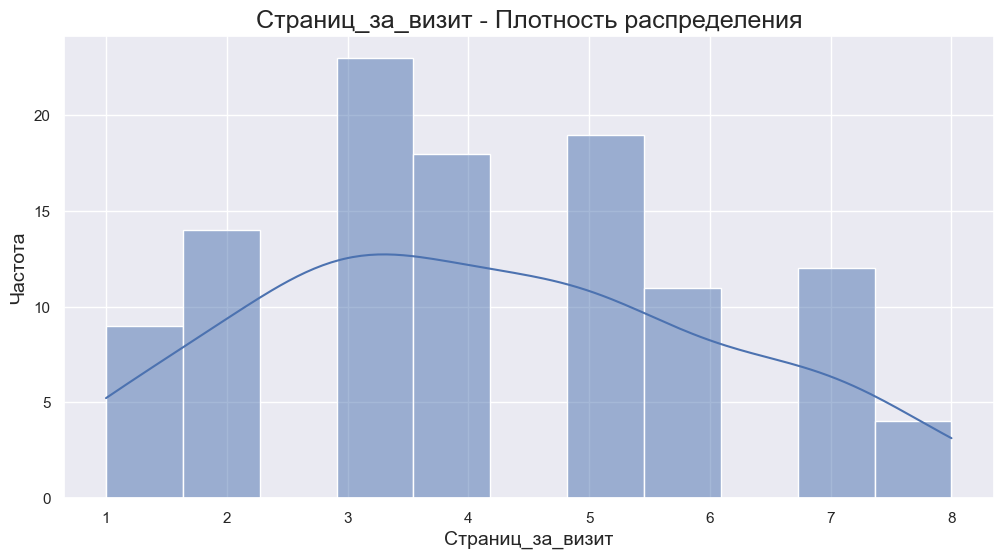

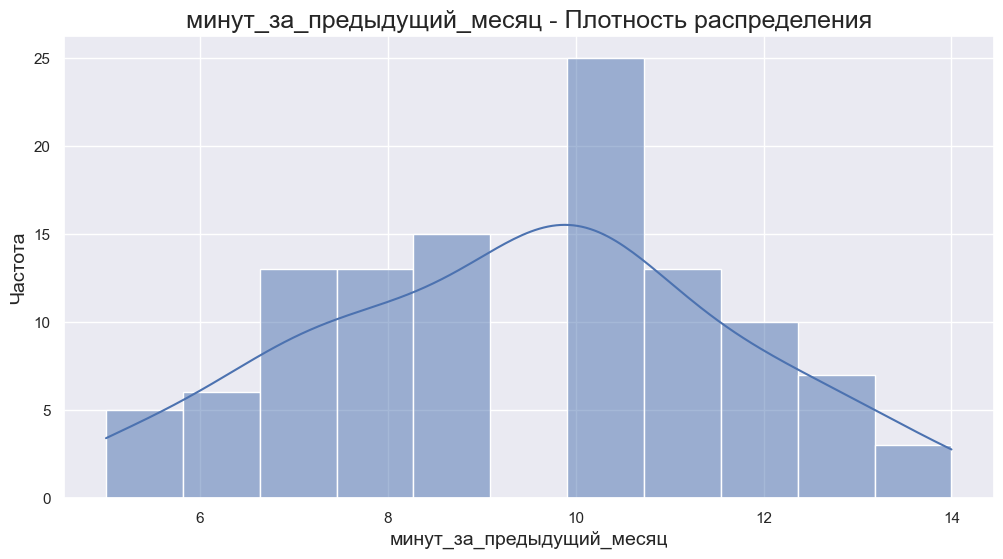

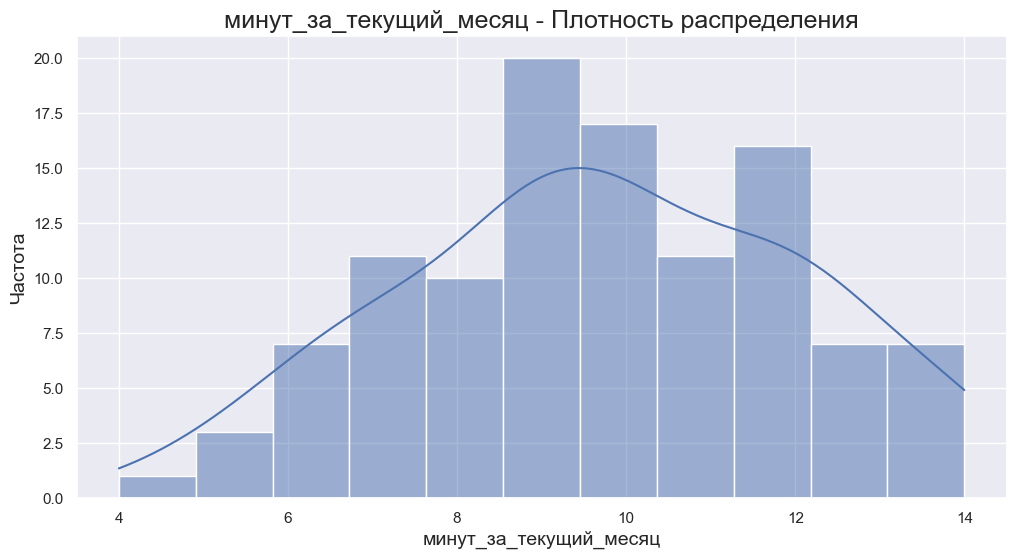

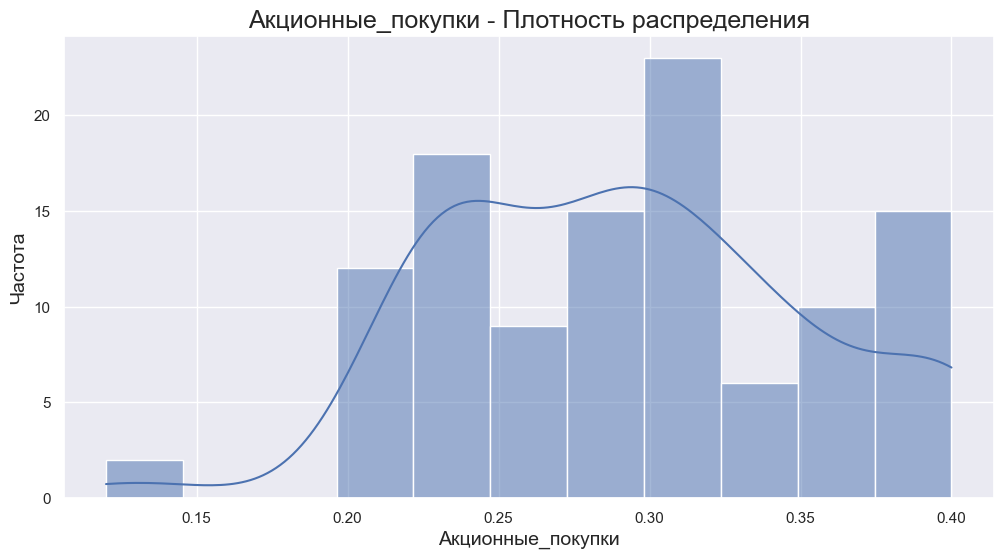

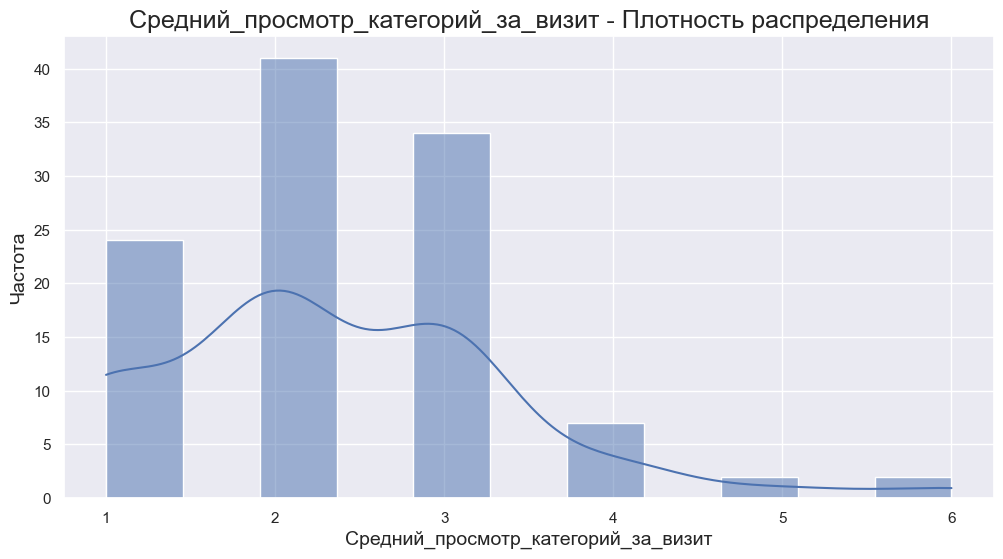

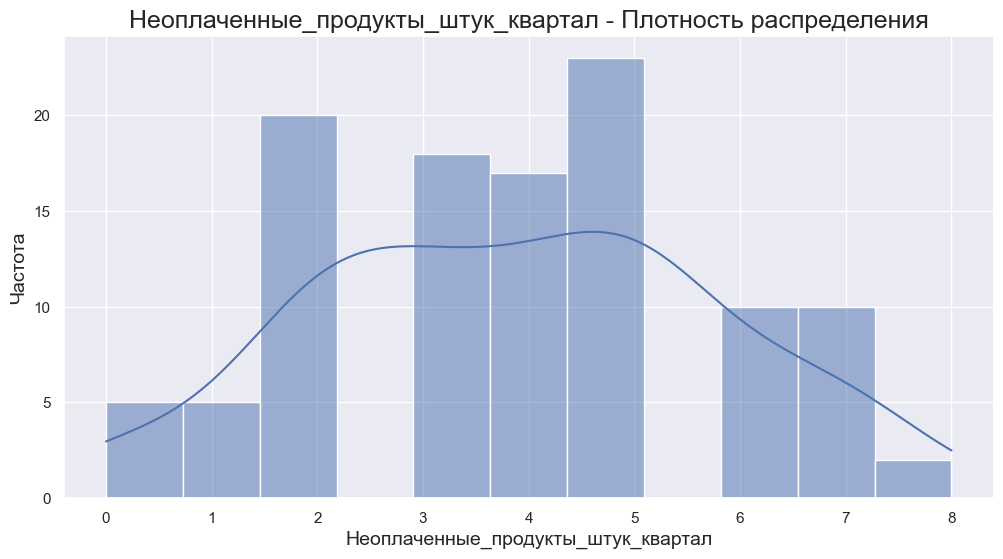

In [69]:
for num in num_reserch:
    create_histogram(df_reserch, num)

### Вывод 
* В качестве целевой аудитории, на которых можно было бы улучшать покупательскую активность - выбрали покупателей с высокой прибылью(от 0.4) и высокой вероятностью снижения активности(выше 70%)
* Таким образом мы видим, что у наших отобранных покупателей самая популярная категория - товары для детей, видно, что акционные покупки пользуются спросом, а у большинства покупателей разрешена рассылка. Из этого можно сделать персональные акции на популярную категорию у каждого покупателя. Либо сезонные акции на детские товары и косметику. 
* Также можно ввести на сайт модель, которая бы анализировала посещение пользователя на сайте и их клики. После чего присылать рассылку с подборкой товаров из популярных категорий
* Можно разработать стратегию для неоплаченных покупок. Например, напоминание через рассылку о том, что стоит оплатить покупки. Или с письмом для обратной связи,если возникли проблемы при оплате. 



<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Молодец, в разделе выбора сегмента и разработки маркетиговых предложений по увеличению покупательской активности для него я не вижу никаких проблем. Проведен и аналитический и графический анализ, в выводе находится саммари по всем, наиболее значимым поинтам анализа. Что же касается рекомендаций, то конечно здесь написать можно много ... твой анализ (и графики для признаков) дают массу полезной информации о характеристиках 2х групп покупателей. Написать можно много, но для начала достаточно и тех моментов, которые упоминаешь здесь ты. Молодец!
</div>

# Вывод

Задача: Разработать и внедрить систему персонализированных предложений для постоянных клиентов интернет-магазина "В один клик" с целью удержания активности постоянных клиентов и увеличения их покупательской активности.

В исходных данных было 4 файла: 
* market_file.csv. Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* market_money.csv. Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* market_time.csv. Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* money.csv. Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

В предобработке данных были удалены неявные дубликаты в названиях периодов, а также удалены выбросы. 
Для поиска лучшей модели выбрали KNeighborsClassifier()DecisionTreeClassifier(), LogisticRegression() и  SVC() с гиперпараметрами. Лучшей моделью стала SVC(C=0.1, degree=2, gamma=10, kernel='linear',probability=True, random_state=42). Метрика лучшей модели на тренировочной выборке: 0.8973337035665804
Метрика ROC-AUC на тестовой выборке: 0.8467886178861789

По анализу важности признаков и выбранных покупателей можно сделать следующие стратегии:
1) Можно сделать персональные акции на популярную категорию у каждого покупателя. Либо сезонные акции на детские товары и косметику. 
2) Предложение ввести на сайт модель, которая бы анализировала посещение пользователя на сайте и их клики. После чего присылать рассылку с подборкой товаров из популярных категорий
3) Разработать стратегию для неоплаченных покупок. Например, напоминание через рассылку о том, что стоит оплатить покупки. Или с письмом для обратной связи,если возникли проблемы при оплате. 

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Всё отлично, результат достигнут. Требованиям ТЗ твой проект полностью устраивает.

Ну и вывод - гуд! И полно и точно описана суть твоей работы. Результат достигнут!</div>

# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Всё это в целом упрощает твой код и одновременно показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Однако есть принципиальные моменты, которые не позволяют мне принять твой проект в его нынешнем состоянии:

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b> 

1. (25) Вместе с гистограммами следует использовать также и boxplot'ы ("ящики с усами" покажут и выбросы и основные статистики данных (квартили)). Почему гистограмму и ящик с усами надо использовать вместе? Первый хорошо показывает бимодальность, второй бимодальность не видит, но хорошо видит выбросы.

2. (25) Провалы в значениях гистограммы реально существуют? Или они появляются ввиду ошибочно выбранного значения bins?    
    
3. (49) В задаче классификации, когда у тебя несколько классов (как у нас: "активность снизилась" и "активность преждняя"), то настоятельно рекомендую корреляционный анализ (с визуализацией и расчетом коэффициентов) проводить отдельно для каждого класса!!! Если это делать на данных одновременно для 2х (и более классов - такие могут быть ситуации), то "картинка может быть смазанной"! Очень легко НЕ УВИДЕТЬ взаимосвязи присущие тому или иному классу.
</div>

Эти 3 момента требуют твоего внимания. Комментарии по ним помечены красным цветом. 

Подводя итог: хорошая работа на самом-то деле, молодец! Есть несколько моментов к исправлению, но уверен, что они не вызовут у тебя сложностей. После доработки обязательно проверь комментарии и выводы. Их нужно будет скорректировать. Жду доработанную версию проекта на повторное ревью.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Постаралась все исправить, если будут еще замечания - обязательноих исправлю на повторном ревью :) </font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Елизавета, был рад помочь! Был рад работать с тобой совместно над проектом! ПРОЕКТ ПРИНЯТ!
</div>